In [2]:
import pandas as pd
import numpy as np
import random
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


c:\Users\CPN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# ===== 1. ĐỌC DỮ LIỆU =====
df = pd.read_excel("carprice_clean.xlsx", sheet_name=0, engine="openpyxl")
df.drop(columns=['mileage', 'torque', 'mileage_numeric', 'mileage_unit', 'torque_unit_extracted'], inplace=True)


In [4]:

# ===== 2. Khai báo biến =====
target_variable = 'selling_price'
numerical_cols = ['year', 'km_driven', 'engine', 'max_power', 'seats',
                  'mileage_kmpl_equivalent', 'torque_Nm']
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']


In [5]:

# ===== 3. Train-test split =====
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [6]:

# ===== 4. Transformer: Target Encoding smooth =====
class TargetEncoderSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, cols, alpha=5):
        self.cols = cols
        self.alpha = alpha
        self.smoothing_dict_ = {}

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        for col in self.cols:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            agg = df_temp.groupby(col)['target'].agg(['mean','count'])
            smooth = (agg['mean'] * agg['count'] + self.global_mean_ * self.alpha) / (agg['count'] + self.alpha)
            self.smoothing_dict_[col] = smooth.to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            mapping = self.smoothing_dict_[col]
            X_copy[col + '_te'] = X_copy[col].map(mapping).fillna(self.global_mean_)
            X_copy.drop(columns=[col], inplace=True)
        return X_copy


In [11]:
# ===== 5. Tạo pipeline chung cho LightGBM =====
encoded_features = ['fuel', 'seller_type', 'transmission']  # OneHot
te_features = ['name', 'owner']                             # TargetEncode
all_features = numerical_cols + te_features + encoded_features

from copy import deepcopy

def build_pipeline(feature_subset, params=None):
    # Steps: target encode, one-hot categorical, passthrough numeric
    preprocessor = ColumnTransformer(transformers=[
        ('te', TargetEncoderSmooth(cols=[f for f in feature_subset if f in te_features]),
             [f for f in feature_subset if f in te_features]),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
             [f for f in feature_subset if f in encoded_features])
    ], remainder='passthrough')  # numeric_cols passthrough

    if params:
        model = LGBMRegressor(**params)
    else:
        model = LGBMRegressor(
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )

    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    return pipeline

Selected: ['year', 'max_power', 'seats', 'mileage_kmpl_equivalent', 'torque_Nm', 'name', 'owner', 'fuel', 'transmission'], RMSE: 158977.67


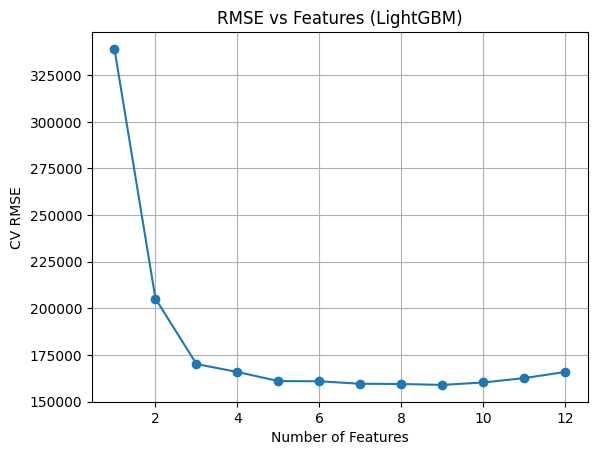

In [12]:

# ===== 6. Backward feature selection =====
X = train_df[all_features]
y = train_df[target_variable]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
history = []

def default_params():
    return {'random_state':42, 'n_jobs':1, 'verbose':-1}

# Đánh giá full model
full_pipe = build_pipeline(all_features, params=default_params())
full_rmse = -cross_val_score(full_pipe, X, y, scoring='neg_root_mean_squared_error', cv=kf).mean()
history.append((deepcopy(all_features), full_rmse))

features = deepcopy(all_features)
while len(features) > 1:
    scores = {}
    for feat in features:
        subset = [f for f in features if f != feat]
        rmse = -cross_val_score(build_pipeline(subset, params=default_params()),
                                 X[subset], y, scoring='neg_root_mean_squared_error', cv=kf).mean()
        scores[feat] = rmse
    worst = min(scores, key=scores.get)
    features.remove(worst)
    history.append((features.copy(), scores[worst]))

best_feats, best_rmse = min(history, key=lambda x: x[1])
print(f"Selected: {best_feats}, RMSE: {best_rmse:.2f}")

# Plot RMSE
import matplotlib.pyplot as plt
df_rmse = pd.DataFrame({'n_features':[len(f) for f,_ in history],'rmse':[r for _,r in history]})
plt.plot(df_rmse['n_features'], df_rmse['rmse'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV RMSE')
plt.title('RMSE vs Features (LightGBM)')
plt.grid(True)
plt.show()


In [13]:

# ===== 7. Optuna tuning LightGBM =====
SEED=42
random.seed(SEED)
np.random.seed(SEED)

X_train_sub = train_df[best_feats]
y_train_sub = train_df[target_variable]

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',300,1500),
        'max_depth': trial.suggest_int('max_depth',3,15),
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.3,log=True),
        'subsample': trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',0.0,5.0),
        'reg_lambda': trial.suggest_float('reg_lambda',0.0,5.0),
        'random_state': SEED,
        'n_jobs':1,
        'verbose':-1
    }
    pipe = build_pipeline(best_feats, params=params)
    rmse = -cross_val_score(pipe, X_train_sub, y_train_sub,
                             scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
    return rmse

study.optimize(objective, n_trials=100, show_progress_bar=True)
print('Best RMSE:',round(study.best_value,2))
print('Best params:',study.best_params)


[I 2025-06-17 16:22:23,773] A new study created in memory with name: no-name-5795b36b-85f6-42b8-860e-74a354f808f2
Best trial: 0. Best value: 158547:   1%|          | 1/100 [00:04<07:32,  4.57s/it]

[I 2025-06-17 16:22:28,424] Trial 0 finished with value: 158546.71557449526 and parameters: {'n_estimators': 749, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.2904180608409973}. Best is trial 0 with value: 158546.71557449526.


Best trial: 1. Best value: 156519:   2%|▏         | 2/100 [00:11<10:09,  6.21s/it]

[I 2025-06-17 16:22:35,790] Trial 1 finished with value: 156519.39035490825 and parameters: {'n_estimators': 1340, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.0616955533913808}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   3%|▎         | 3/100 [00:13<06:33,  4.06s/it]

[I 2025-06-17 16:22:37,283] Trial 2 finished with value: 168492.693148432 and parameters: {'n_estimators': 518, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 1.4561457009902097, 'reg_lambda': 3.0592644736118975}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   4%|▍         | 4/100 [00:15<04:57,  3.09s/it]

[I 2025-06-17 16:22:38,900] Trial 3 finished with value: 164781.50207936513 and parameters: {'n_estimators': 467, 'max_depth': 6, 'learning_rate': 0.03476649150592621, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 0.9983689107917987, 'reg_lambda': 2.571172192068058}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   5%|▌         | 5/100 [00:16<04:09,  2.62s/it]

[I 2025-06-17 16:22:40,700] Trial 4 finished with value: 170044.3908294433 and parameters: {'n_estimators': 1011, 'max_depth': 3, 'learning_rate': 0.07896186801026692, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 4.7444276862666666, 'reg_lambda': 4.828160165372797}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   6%|▌         | 6/100 [00:21<04:59,  3.18s/it]

[I 2025-06-17 16:22:44,973] Trial 5 finished with value: 162619.24436706785 and parameters: {'n_estimators': 1270, 'max_depth': 6, 'learning_rate': 0.013940346079873234, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.6101911742238941, 'reg_lambda': 2.475884550556351}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   7%|▋         | 7/100 [00:22<04:16,  2.76s/it]

[I 2025-06-17 16:22:46,848] Trial 6 finished with value: 163610.9216545085 and parameters: {'n_estimators': 341, 'max_depth': 14, 'learning_rate': 0.024112898115291985, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 2.600340105889054, 'reg_lambda': 2.7335513967163982}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   8%|▊         | 8/100 [00:26<04:24,  2.88s/it]

[I 2025-06-17 16:22:49,978] Trial 7 finished with value: 160428.41743108636 and parameters: {'n_estimators': 522, 'max_depth': 15, 'learning_rate': 0.13962563737015762, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 2.9894998940554256, 'reg_lambda': 4.609371175115584}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:   9%|▉         | 9/100 [00:27<03:40,  2.42s/it]

[I 2025-06-17 16:22:51,396] Trial 8 finished with value: 178103.32660601469 and parameters: {'n_estimators': 406, 'max_depth': 5, 'learning_rate': 0.011662890273931383, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:  10%|█         | 10/100 [00:29<03:33,  2.37s/it]

[I 2025-06-17 16:22:53,653] Trial 9 finished with value: 162761.3251080679 and parameters: {'n_estimators': 728, 'max_depth': 6, 'learning_rate': 0.06333268775321843, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.3727532183988541, 'reg_lambda': 4.9344346830025865}. Best is trial 1 with value: 156519.39035490825.


Best trial: 1. Best value: 156519:  11%|█         | 11/100 [00:37<06:08,  4.14s/it]

[I 2025-06-17 16:23:01,796] Trial 10 finished with value: 161636.01955165234 and parameters: {'n_estimators': 1475, 'max_depth': 11, 'learning_rate': 0.2704729722717779, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8259332753890893, 'reg_alpha': 4.53832397641259, 'reg_lambda': 0.4044381318692345}. Best is trial 1 with value: 156519.39035490825.


Best trial: 11. Best value: 156026:  12%|█▏        | 12/100 [00:42<06:16,  4.28s/it]

[I 2025-06-17 16:23:06,415] Trial 11 finished with value: 156025.7188372066 and parameters: {'n_estimators': 950, 'max_depth': 11, 'learning_rate': 0.12322945413760499, 'subsample': 0.9294632818743329, 'colsample_bytree': 0.5046138345222255, 'reg_alpha': 3.530042849428194, 'reg_lambda': 0.19121386233135113}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  13%|█▎        | 13/100 [00:48<06:52,  4.74s/it]

[I 2025-06-17 16:23:12,196] Trial 12 finished with value: 161865.5735621492 and parameters: {'n_estimators': 1106, 'max_depth': 10, 'learning_rate': 0.22514439322776278, 'subsample': 0.9990220294624489, 'colsample_bytree': 0.8134854000007805, 'reg_alpha': 3.802129717754032, 'reg_lambda': 1.3232981648188953}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  14%|█▍        | 14/100 [00:57<08:41,  6.07s/it]

[I 2025-06-17 16:23:21,347] Trial 13 finished with value: 160236.0821339442 and parameters: {'n_estimators': 1499, 'max_depth': 11, 'learning_rate': 0.12469670511407127, 'subsample': 0.9076813412842808, 'colsample_bytree': 0.9828472877209871, 'reg_alpha': 3.5318365108210483, 'reg_lambda': 1.1356950582543934}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  15%|█▌        | 15/100 [01:02<08:06,  5.72s/it]

[I 2025-06-17 16:23:26,255] Trial 14 finished with value: 160259.00162297924 and parameters: {'n_estimators': 1290, 'max_depth': 8, 'learning_rate': 0.08834239156031728, 'subsample': 0.7084623041637503, 'colsample_bytree': 0.6123366282341045, 'reg_alpha': 3.9906824080147745, 'reg_lambda': 1.3266621427588747}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  16%|█▌        | 16/100 [01:06<07:19,  5.24s/it]

[I 2025-06-17 16:23:30,370] Trial 15 finished with value: 156479.9880386627 and parameters: {'n_estimators': 854, 'max_depth': 13, 'learning_rate': 0.17173227791551512, 'subsample': 0.9040330172235821, 'colsample_bytree': 0.501562691272464, 'reg_alpha': 2.067070498463565, 'reg_lambda': 0.11076467309077995}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  17%|█▋        | 17/100 [01:10<06:48,  4.92s/it]

[I 2025-06-17 16:23:34,555] Trial 16 finished with value: 156999.8427489791 and parameters: {'n_estimators': 833, 'max_depth': 13, 'learning_rate': 0.2083833461459854, 'subsample': 0.8978366926124223, 'colsample_bytree': 0.510359540116337, 'reg_alpha': 2.0761656853804564, 'reg_lambda': 0.05494594621885662}. Best is trial 11 with value: 156025.7188372066.


Best trial: 11. Best value: 156026:  18%|█▊        | 18/100 [01:15<06:50,  5.00s/it]

[I 2025-06-17 16:23:39,738] Trial 17 finished with value: 158137.33951431484 and parameters: {'n_estimators': 1015, 'max_depth': 13, 'learning_rate': 0.04848754515310095, 'subsample': 0.9211228914916701, 'colsample_bytree': 0.5751296621701932, 'reg_alpha': 3.158640549398224, 'reg_lambda': 1.9709728594039826}. Best is trial 11 with value: 156025.7188372066.


Best trial: 18. Best value: 155860:  19%|█▉        | 19/100 [01:19<06:02,  4.48s/it]

[I 2025-06-17 16:23:43,004] Trial 18 finished with value: 155859.9327705655 and parameters: {'n_estimators': 671, 'max_depth': 12, 'learning_rate': 0.174411594011689, 'subsample': 0.8754986180062629, 'colsample_bytree': 0.5002331985467168, 'reg_alpha': 2.0161982752085867, 'reg_lambda': 0.6996633963824056}. Best is trial 18 with value: 155859.9327705655.


Best trial: 18. Best value: 155860:  20%|██        | 20/100 [01:21<05:13,  3.92s/it]

[I 2025-06-17 16:23:45,616] Trial 19 finished with value: 161819.21408023586 and parameters: {'n_estimators': 631, 'max_depth': 8, 'learning_rate': 0.17150723747557747, 'subsample': 0.8567863972205803, 'colsample_bytree': 0.6339001830733001, 'reg_alpha': 2.180499167861401, 'reg_lambda': 0.6859078002167498}. Best is trial 18 with value: 155859.9327705655.


Best trial: 18. Best value: 155860:  21%|██        | 21/100 [01:27<05:43,  4.35s/it]

[I 2025-06-17 16:23:50,985] Trial 20 finished with value: 163745.2548867872 and parameters: {'n_estimators': 984, 'max_depth': 12, 'learning_rate': 0.29841032345335666, 'subsample': 0.9667193196726512, 'colsample_bytree': 0.7825269757813548, 'reg_alpha': 2.57127579139316, 'reg_lambda': 1.7151421798173652}. Best is trial 18 with value: 155859.9327705655.


Best trial: 21. Best value: 155688:  22%|██▏       | 22/100 [01:31<05:31,  4.26s/it]

[I 2025-06-17 16:23:55,014] Trial 21 finished with value: 155687.63542088962 and parameters: {'n_estimators': 845, 'max_depth': 12, 'learning_rate': 0.18625066448976338, 'subsample': 0.8832615669309692, 'colsample_bytree': 0.5008009849088533, 'reg_alpha': 1.8048545550336268, 'reg_lambda': 0.5776000101886138}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  23%|██▎       | 23/100 [01:34<05:07,  3.99s/it]

[I 2025-06-17 16:23:58,398] Trial 22 finished with value: 162310.26866205366 and parameters: {'n_estimators': 661, 'max_depth': 11, 'learning_rate': 0.167999236429683, 'subsample': 0.7890532893760417, 'colsample_bytree': 0.5586652016290691, 'reg_alpha': 1.6858435331495683, 'reg_lambda': 0.6750123238812648}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  24%|██▍       | 24/100 [01:38<04:57,  3.92s/it]

[I 2025-06-17 16:24:02,146] Trial 23 finished with value: 157513.55197555147 and parameters: {'n_estimators': 921, 'max_depth': 9, 'learning_rate': 0.07851725528116825, 'subsample': 0.9395414056200823, 'colsample_bytree': 0.548440512773818, 'reg_alpha': 3.098233891552642, 'reg_lambda': 0.7390187361522057}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  25%|██▌       | 25/100 [01:44<05:35,  4.47s/it]

[I 2025-06-17 16:24:07,900] Trial 24 finished with value: 160737.3942523174 and parameters: {'n_estimators': 1147, 'max_depth': 12, 'learning_rate': 0.10262523980364116, 'subsample': 0.865292834124193, 'colsample_bytree': 0.6049493666586457, 'reg_alpha': 0.017325207460714864, 'reg_lambda': 1.829249951874854}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  26%|██▌       | 26/100 [01:47<05:17,  4.29s/it]

[I 2025-06-17 16:24:11,779] Trial 25 finished with value: 156931.50016470553 and parameters: {'n_estimators': 778, 'max_depth': 12, 'learning_rate': 0.04942805001894651, 'subsample': 0.8762428782199592, 'colsample_bytree': 0.5068619691154281, 'reg_alpha': 1.708751158066085, 'reg_lambda': 0.8513751432878538}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  27%|██▋       | 27/100 [01:50<04:44,  3.89s/it]

[I 2025-06-17 16:24:14,746] Trial 26 finished with value: 162362.99115238155 and parameters: {'n_estimators': 637, 'max_depth': 9, 'learning_rate': 0.22628850939836312, 'subsample': 0.8106452018417596, 'colsample_bytree': 0.6610679688214769, 'reg_alpha': 2.8495273781487027, 'reg_lambda': 3.735437997054583}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  28%|██▊       | 28/100 [01:55<05:00,  4.18s/it]

[I 2025-06-17 16:24:19,574] Trial 27 finished with value: 161903.8117007967 and parameters: {'n_estimators': 927, 'max_depth': 14, 'learning_rate': 0.1464008702676321, 'subsample': 0.9981252342912676, 'colsample_bytree': 0.5854824376835572, 'reg_alpha': 3.520871285213353, 'reg_lambda': 0.38341156346325533}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  29%|██▉       | 29/100 [02:01<05:38,  4.77s/it]

[I 2025-06-17 16:24:25,739] Trial 28 finished with value: 161474.18984200121 and parameters: {'n_estimators': 1114, 'max_depth': 11, 'learning_rate': 0.18969471766945203, 'subsample': 0.9438245048353373, 'colsample_bytree': 0.532662148023123, 'reg_alpha': 2.3363747059365756, 'reg_lambda': 1.589690380796597}. Best is trial 21 with value: 155687.63542088962.


Best trial: 21. Best value: 155688:  30%|███       | 30/100 [02:05<05:17,  4.53s/it]

[I 2025-06-17 16:24:29,722] Trial 29 finished with value: 158783.73983215942 and parameters: {'n_estimators': 748, 'max_depth': 15, 'learning_rate': 0.06623993157417352, 'subsample': 0.7736937330152542, 'colsample_bytree': 0.5749945646361971, 'reg_alpha': 1.0633231792683706, 'reg_lambda': 2.2012199008004876}. Best is trial 21 with value: 155687.63542088962.


Best trial: 30. Best value: 155508:  31%|███       | 31/100 [02:08<04:32,  3.95s/it]

[I 2025-06-17 16:24:32,321] Trial 30 finished with value: 155508.07099933934 and parameters: {'n_estimators': 588, 'max_depth': 10, 'learning_rate': 0.1277657404508875, 'subsample': 0.8265137032920471, 'colsample_bytree': 0.5409164776210665, 'reg_alpha': 1.7777614684593972, 'reg_lambda': 0.3990314851547528}. Best is trial 30 with value: 155508.07099933934.


Best trial: 31. Best value: 155063:  32%|███▏      | 32/100 [02:11<04:06,  3.62s/it]

[I 2025-06-17 16:24:35,173] Trial 31 finished with value: 155062.81857694435 and parameters: {'n_estimators': 608, 'max_depth': 10, 'learning_rate': 0.10345584222375197, 'subsample': 0.8167834704380931, 'colsample_bytree': 0.5417542224767021, 'reg_alpha': 1.788802179517096, 'reg_lambda': 0.36619017939880555}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  33%|███▎      | 33/100 [02:13<03:41,  3.31s/it]

[I 2025-06-17 16:24:37,737] Trial 32 finished with value: 156364.48950106205 and parameters: {'n_estimators': 572, 'max_depth': 10, 'learning_rate': 0.09978589179620714, 'subsample': 0.8025853276391405, 'colsample_bytree': 0.5434356056489703, 'reg_alpha': 1.7580625250672812, 'reg_lambda': 0.4164156765813628}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  34%|███▍      | 34/100 [02:16<03:28,  3.16s/it]

[I 2025-06-17 16:24:40,557] Trial 33 finished with value: 157529.97706330376 and parameters: {'n_estimators': 702, 'max_depth': 8, 'learning_rate': 0.1447657378680096, 'subsample': 0.8312691035738079, 'colsample_bytree': 0.6031523627463751, 'reg_alpha': 1.3147156317697517, 'reg_lambda': 1.0674287382082281}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  35%|███▌      | 35/100 [02:18<03:08,  2.90s/it]

[I 2025-06-17 16:24:42,841] Trial 34 finished with value: 158957.19131994346 and parameters: {'n_estimators': 467, 'max_depth': 10, 'learning_rate': 0.24496203721797177, 'subsample': 0.7400886590206679, 'colsample_bytree': 0.5363661178080554, 'reg_alpha': 1.9178787201115486, 'reg_lambda': 0.4910345029311397}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  36%|███▌      | 36/100 [02:22<03:17,  3.09s/it]

[I 2025-06-17 16:24:46,384] Trial 35 finished with value: 157871.83744628986 and parameters: {'n_estimators': 821, 'max_depth': 9, 'learning_rate': 0.11008262136301321, 'subsample': 0.6986396182085534, 'colsample_bytree': 0.6421585777238812, 'reg_alpha': 1.0730958483735922, 'reg_lambda': 0.8791733582466879}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  37%|███▋      | 37/100 [02:25<03:13,  3.08s/it]

[I 2025-06-17 16:24:49,433] Trial 36 finished with value: 158795.8863314933 and parameters: {'n_estimators': 560, 'max_depth': 12, 'learning_rate': 0.03805849268351078, 'subsample': 0.8800387804602499, 'colsample_bytree': 0.5662895513944918, 'reg_alpha': 1.5259468345331777, 'reg_lambda': 1.3628329977182827}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  38%|███▊      | 38/100 [02:28<03:00,  2.91s/it]

[I 2025-06-17 16:24:51,951] Trial 37 finished with value: 159466.30429436133 and parameters: {'n_estimators': 384, 'max_depth': 14, 'learning_rate': 0.09130993380675868, 'subsample': 0.8212781535939365, 'colsample_bytree': 0.6776936071181332, 'reg_alpha': 2.3921975583945696, 'reg_lambda': 0.02529573424182774}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  39%|███▉      | 39/100 [02:29<02:27,  2.42s/it]

[I 2025-06-17 16:24:53,199] Trial 38 finished with value: 160425.0034617399 and parameters: {'n_estimators': 301, 'max_depth': 7, 'learning_rate': 0.07393695724374062, 'subsample': 0.7723986108108875, 'colsample_bytree': 0.7505026631019919, 'reg_alpha': 0.6498164161058104, 'reg_lambda': 3.0029094746249885}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  40%|████      | 40/100 [02:30<01:58,  1.97s/it]

[I 2025-06-17 16:24:54,139] Trial 39 finished with value: 167355.39306117053 and parameters: {'n_estimators': 461, 'max_depth': 3, 'learning_rate': 0.1366171922869867, 'subsample': 0.8553791061819456, 'colsample_bytree': 0.532640198880335, 'reg_alpha': 1.2395791957980524, 'reg_lambda': 1.0530297634027563}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  41%|████      | 41/100 [02:33<02:12,  2.24s/it]

[I 2025-06-17 16:24:57,015] Trial 40 finished with value: 163355.98578265723 and parameters: {'n_estimators': 589, 'max_depth': 10, 'learning_rate': 0.17870242731597372, 'subsample': 0.6546271274853921, 'colsample_bytree': 0.621757277239386, 'reg_alpha': 2.7784075382974422, 'reg_lambda': 0.5152017084118449}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  42%|████▏     | 42/100 [02:36<02:24,  2.50s/it]

[I 2025-06-17 16:25:00,117] Trial 41 finished with value: 156145.2182288604 and parameters: {'n_estimators': 677, 'max_depth': 11, 'learning_rate': 0.11556851677731034, 'subsample': 0.8844302319577306, 'colsample_bytree': 0.5066648787644931, 'reg_alpha': 1.9788089399851034, 'reg_lambda': 0.21386745342530142}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  43%|████▎     | 43/100 [02:40<02:45,  2.91s/it]

[I 2025-06-17 16:25:03,961] Trial 42 finished with value: 157182.40418493975 and parameters: {'n_estimators': 773, 'max_depth': 13, 'learning_rate': 0.14473690969705827, 'subsample': 0.9333486550882425, 'colsample_bytree': 0.5224902907621677, 'reg_alpha': 1.5487052548374498, 'reg_lambda': 0.26378004201570926}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  44%|████▍     | 44/100 [02:42<02:39,  2.85s/it]

[I 2025-06-17 16:25:06,679] Trial 43 finished with value: 163533.58948616977 and parameters: {'n_estimators': 508, 'max_depth': 12, 'learning_rate': 0.19351435700877187, 'subsample': 0.9649425676988236, 'colsample_bytree': 0.5876592649472051, 'reg_alpha': 4.899226356996809, 'reg_lambda': 0.6215697794781216}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  45%|████▌     | 45/100 [02:47<03:13,  3.52s/it]

[I 2025-06-17 16:25:11,748] Trial 44 finished with value: 157050.25003591 and parameters: {'n_estimators': 1047, 'max_depth': 10, 'learning_rate': 0.019012162638009204, 'subsample': 0.79347583588645, 'colsample_bytree': 0.557990074778136, 'reg_alpha': 4.362726734130202, 'reg_lambda': 0.9095414245442421}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  46%|████▌     | 46/100 [02:52<03:26,  3.83s/it]

[I 2025-06-17 16:25:16,324] Trial 45 finished with value: 157270.47779592522 and parameters: {'n_estimators': 937, 'max_depth': 11, 'learning_rate': 0.12336423152953721, 'subsample': 0.8419665919399483, 'colsample_bytree': 0.5004168691522362, 'reg_alpha': 0.8677598528245309, 'reg_lambda': 0.2602734222518931}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  47%|████▋     | 47/100 [02:56<03:23,  3.84s/it]

[I 2025-06-17 16:25:20,175] Trial 46 finished with value: 159827.76426992464 and parameters: {'n_estimators': 858, 'max_depth': 10, 'learning_rate': 0.262071756981513, 'subsample': 0.8440403788959142, 'colsample_bytree': 0.5300789413817879, 'reg_alpha': 1.8321115421712595, 'reg_lambda': 1.5146062830230187}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  48%|████▊     | 48/100 [02:59<03:17,  3.79s/it]

[I 2025-06-17 16:25:23,857] Trial 47 finished with value: 162752.95293093612 and parameters: {'n_estimators': 718, 'max_depth': 11, 'learning_rate': 0.09597454359840213, 'subsample': 0.8971747627302167, 'colsample_bytree': 0.8753350342223254, 'reg_alpha': 2.2601494789119037, 'reg_lambda': 3.659649060474179}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  49%|████▉     | 49/100 [03:02<03:01,  3.55s/it]

[I 2025-06-17 16:25:26,848] Trial 48 finished with value: 158183.7110741051 and parameters: {'n_estimators': 597, 'max_depth': 9, 'learning_rate': 0.05921360533538313, 'subsample': 0.8691469380313281, 'colsample_bytree': 0.5513759454767393, 'reg_alpha': 3.4749359049840005, 'reg_lambda': 0.0128125441335033}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  50%|█████     | 50/100 [03:09<03:40,  4.42s/it]

[I 2025-06-17 16:25:33,288] Trial 49 finished with value: 161437.31524079753 and parameters: {'n_estimators': 1213, 'max_depth': 12, 'learning_rate': 0.1307399645038607, 'subsample': 0.9198391713704948, 'colsample_bytree': 0.5937518808838633, 'reg_alpha': 2.5294100058736713, 'reg_lambda': 1.1562196383187355}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  51%|█████     | 51/100 [03:13<03:34,  4.39s/it]

[I 2025-06-17 16:25:37,604] Trial 50 finished with value: 162673.4180152433 and parameters: {'n_estimators': 801, 'max_depth': 13, 'learning_rate': 0.15776487523206553, 'subsample': 0.7568408158409166, 'colsample_bytree': 0.724210320184054, 'reg_alpha': 2.787350608319899, 'reg_lambda': 0.54791525382814}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  52%|█████▏    | 52/100 [03:16<03:11,  3.98s/it]

[I 2025-06-17 16:25:40,637] Trial 51 finished with value: 156442.51783923962 and parameters: {'n_estimators': 675, 'max_depth': 11, 'learning_rate': 0.11549366068861046, 'subsample': 0.8936749341378322, 'colsample_bytree': 0.5161403876953072, 'reg_alpha': 2.0366642198041442, 'reg_lambda': 0.29901938977346054}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  53%|█████▎    | 53/100 [03:20<03:06,  3.98s/it]

[I 2025-06-17 16:25:44,608] Trial 52 finished with value: 160003.6158840778 and parameters: {'n_estimators': 874, 'max_depth': 11, 'learning_rate': 0.21363314771546205, 'subsample': 0.8800884082088614, 'colsample_bytree': 0.5037290312303339, 'reg_alpha': 1.9421278265222564, 'reg_lambda': 0.3250139909667461}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  54%|█████▍    | 54/100 [03:23<02:42,  3.54s/it]

[I 2025-06-17 16:25:47,118] Trial 53 finished with value: 155391.73124872596 and parameters: {'n_estimators': 499, 'max_depth': 12, 'learning_rate': 0.08654016983876708, 'subsample': 0.8268830589081688, 'colsample_bytree': 0.5182285737958752, 'reg_alpha': 1.492531818208544, 'reg_lambda': 0.19660340199651272}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  55%|█████▌    | 55/100 [03:25<02:28,  3.30s/it]

[I 2025-06-17 16:25:49,855] Trial 54 finished with value: 158266.82889898328 and parameters: {'n_estimators': 523, 'max_depth': 14, 'learning_rate': 0.08285391731583758, 'subsample': 0.8205443113526285, 'colsample_bytree': 0.5660744835496172, 'reg_alpha': 1.4031443984402263, 'reg_lambda': 0.7993111490985612}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  56%|█████▌    | 56/100 [03:28<02:09,  2.94s/it]

[I 2025-06-17 16:25:51,967] Trial 55 finished with value: 155411.3499808337 and parameters: {'n_estimators': 431, 'max_depth': 12, 'learning_rate': 0.1610733859232814, 'subsample': 0.8459599072249591, 'colsample_bytree': 0.5225053522020703, 'reg_alpha': 1.5754031146410998, 'reg_lambda': 0.6252971470767599}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  57%|█████▋    | 57/100 [03:30<01:57,  2.73s/it]

[I 2025-06-17 16:25:54,188] Trial 56 finished with value: 156046.35629737584 and parameters: {'n_estimators': 419, 'max_depth': 13, 'learning_rate': 0.15946000069500071, 'subsample': 0.784029915345883, 'colsample_bytree': 0.5260451286377729, 'reg_alpha': 1.5937323591435713, 'reg_lambda': 0.9778367831326289}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  58%|█████▊    | 58/100 [03:32<01:42,  2.44s/it]

[I 2025-06-17 16:25:55,950] Trial 57 finished with value: 156675.91483052663 and parameters: {'n_estimators': 390, 'max_depth': 12, 'learning_rate': 0.07201282530444808, 'subsample': 0.8453383387243193, 'colsample_bytree': 0.5485490124589184, 'reg_alpha': 1.2114406479554118, 'reg_lambda': 1.2428840249285553}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  59%|█████▉    | 59/100 [03:33<01:26,  2.11s/it]

[I 2025-06-17 16:25:57,285] Trial 58 finished with value: 168025.06397257544 and parameters: {'n_estimators': 528, 'max_depth': 4, 'learning_rate': 0.2976018473440824, 'subsample': 0.8116496596765876, 'colsample_bytree': 0.5728592208755152, 'reg_alpha': 2.1214395554146184, 'reg_lambda': 0.7152194469084419}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  60%|██████    | 60/100 [03:36<01:37,  2.45s/it]

[I 2025-06-17 16:26:00,537] Trial 59 finished with value: 157219.35582631448 and parameters: {'n_estimators': 480, 'max_depth': 13, 'learning_rate': 0.19746964949992912, 'subsample': 0.7183974979799032, 'colsample_bytree': 0.5229243385042984, 'reg_alpha': 0.8295199828238072, 'reg_lambda': 0.5400530086079547}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  61%|██████    | 61/100 [03:40<01:53,  2.91s/it]

[I 2025-06-17 16:26:04,501] Trial 60 finished with value: 156059.4348688828 and parameters: {'n_estimators': 616, 'max_depth': 12, 'learning_rate': 0.104784896032246, 'subsample': 0.5527938664297325, 'colsample_bytree': 0.5463310615594823, 'reg_alpha': 1.7273941203492988, 'reg_lambda': 0.1470967284923555}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  62%|██████▏   | 62/100 [03:42<01:42,  2.70s/it]

[I 2025-06-17 16:26:06,731] Trial 61 finished with value: 155606.31765839632 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.12892967006728595, 'subsample': 0.8306535860648036, 'colsample_bytree': 0.5006573830480388, 'reg_alpha': 1.4319511712419288, 'reg_lambda': 0.17325121530290144}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  63%|██████▎   | 63/100 [03:44<01:26,  2.33s/it]

[I 2025-06-17 16:26:08,213] Trial 62 finished with value: 156876.39164638147 and parameters: {'n_estimators': 332, 'max_depth': 8, 'learning_rate': 0.1569005568447419, 'subsample': 0.8299712191765716, 'colsample_bytree': 0.525020040359955, 'reg_alpha': 1.4271704031269286, 'reg_lambda': 0.41735914639697236}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  64%|██████▍   | 64/100 [03:46<01:22,  2.29s/it]

[I 2025-06-17 16:26:10,398] Trial 63 finished with value: 156994.66325284433 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.1339864106184835, 'subsample': 0.8572951761427379, 'colsample_bytree': 0.518100179093174, 'reg_alpha': 1.5863053720194207, 'reg_lambda': 0.6877124220245351}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  65%|██████▌   | 65/100 [03:49<01:22,  2.35s/it]

[I 2025-06-17 16:26:12,859] Trial 64 finished with value: 156217.8478192232 and parameters: {'n_estimators': 552, 'max_depth': 9, 'learning_rate': 0.08900661522640482, 'subsample': 0.8064293172275875, 'colsample_bytree': 0.5008552792416195, 'reg_alpha': 1.8392299822128435, 'reg_lambda': 0.1610186338445615}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  66%|██████▌   | 66/100 [03:50<01:12,  2.12s/it]

[I 2025-06-17 16:26:14,475] Trial 65 finished with value: 164417.35458188198 and parameters: {'n_estimators': 361, 'max_depth': 10, 'learning_rate': 0.230858871959022, 'subsample': 0.8345267918028068, 'colsample_bytree': 0.5579345441804304, 'reg_alpha': 1.1063844907478402, 'reg_lambda': 4.4923704326018505}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  67%|██████▋   | 67/100 [03:53<01:19,  2.42s/it]

[I 2025-06-17 16:26:17,594] Trial 66 finished with value: 158355.34848269873 and parameters: {'n_estimators': 636, 'max_depth': 14, 'learning_rate': 0.18777630683208404, 'subsample': 0.7423671432497532, 'colsample_bytree': 0.5384738289626387, 'reg_alpha': 2.181360030748106, 'reg_lambda': 0.43038868057225804}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  68%|██████▊   | 68/100 [03:55<01:11,  2.24s/it]

[I 2025-06-17 16:26:19,410] Trial 67 finished with value: 158731.2061735973 and parameters: {'n_estimators': 515, 'max_depth': 7, 'learning_rate': 0.11844336227639592, 'subsample': 0.8578173948376978, 'colsample_bytree': 0.620630831403338, 'reg_alpha': 2.4208918299121587, 'reg_lambda': 0.9275149864081447}. Best is trial 31 with value: 155062.81857694435.


Best trial: 31. Best value: 155063:  69%|██████▉   | 69/100 [03:57<01:05,  2.11s/it]

[I 2025-06-17 16:26:21,209] Trial 68 finished with value: 161238.40031145787 and parameters: {'n_estimators': 419, 'max_depth': 9, 'learning_rate': 0.17190926805754436, 'subsample': 0.7802992809605733, 'colsample_bytree': 0.5979941092167896, 'reg_alpha': 0.5548464379721183, 'reg_lambda': 0.5776595802848341}. Best is trial 31 with value: 155062.81857694435.


Best trial: 69. Best value: 154055:  70%|███████   | 70/100 [03:59<01:03,  2.13s/it]

[I 2025-06-17 16:26:23,392] Trial 69 finished with value: 154055.38266222298 and parameters: {'n_estimators': 445, 'max_depth': 12, 'learning_rate': 0.10224443515546988, 'subsample': 0.9080214678581298, 'colsample_bytree': 0.5185115186882149, 'reg_alpha': 1.3080278470874382, 'reg_lambda': 0.7867413175769224}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  71%|███████   | 71/100 [04:01<01:03,  2.18s/it]

[I 2025-06-17 16:26:25,691] Trial 70 finished with value: 158775.93213824564 and parameters: {'n_estimators': 431, 'max_depth': 12, 'learning_rate': 0.0841719599541067, 'subsample': 0.9157643014430972, 'colsample_bytree': 0.5859372323078248, 'reg_alpha': 1.2810975168023413, 'reg_lambda': 0.06365930465707195}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  72%|███████▏  | 72/100 [04:04<01:02,  2.22s/it]

[I 2025-06-17 16:26:27,991] Trial 71 finished with value: 154854.33792766638 and parameters: {'n_estimators': 492, 'max_depth': 11, 'learning_rate': 0.10345702804795043, 'subsample': 0.8906808552005225, 'colsample_bytree': 0.518419017868163, 'reg_alpha': 1.6071497631361589, 'reg_lambda': 0.7329893196945894}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  73%|███████▎  | 73/100 [04:06<01:00,  2.25s/it]

[I 2025-06-17 16:26:30,307] Trial 72 finished with value: 155535.2136720839 and parameters: {'n_estimators': 491, 'max_depth': 11, 'learning_rate': 0.10380323280446699, 'subsample': 0.949813689550878, 'colsample_bytree': 0.5406137936311756, 'reg_alpha': 1.4449563320879903, 'reg_lambda': 0.8155263320392847}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  74%|███████▍  | 74/100 [04:08<01:00,  2.33s/it]

[I 2025-06-17 16:26:32,820] Trial 73 finished with value: 156558.44453689762 and parameters: {'n_estimators': 492, 'max_depth': 11, 'learning_rate': 0.10252405708384202, 'subsample': 0.9590245622625586, 'colsample_bytree': 0.5694467914953991, 'reg_alpha': 1.425238024628755, 'reg_lambda': 0.8088149056986655}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  75%|███████▌  | 75/100 [04:10<00:51,  2.08s/it]

[I 2025-06-17 16:26:34,313] Trial 74 finished with value: 158580.10189413914 and parameters: {'n_estimators': 338, 'max_depth': 10, 'learning_rate': 0.07382443187422225, 'subsample': 0.9853889276294475, 'colsample_bytree': 0.5398883591970681, 'reg_alpha': 1.0250866206332492, 'reg_lambda': 2.0992746896790004}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  76%|███████▌  | 76/100 [04:12<00:49,  2.08s/it]

[I 2025-06-17 16:26:36,389] Trial 75 finished with value: 160157.52398181034 and parameters: {'n_estimators': 379, 'max_depth': 11, 'learning_rate': 0.09660650231342575, 'subsample': 0.9451168706613657, 'colsample_bytree': 0.519587995740955, 'reg_alpha': 1.1527723818555562, 'reg_lambda': 2.605187548772436}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  77%|███████▋  | 77/100 [04:15<00:56,  2.46s/it]

[I 2025-06-17 16:26:39,755] Trial 76 finished with value: 156345.64666290313 and parameters: {'n_estimators': 545, 'max_depth': 11, 'learning_rate': 0.0663210137234639, 'subsample': 0.8999583172138632, 'colsample_bytree': 0.9416357520837273, 'reg_alpha': 0.9320366062784078, 'reg_lambda': 1.485986156771009}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  78%|███████▊  | 78/100 [04:18<00:52,  2.40s/it]

[I 2025-06-17 16:26:42,021] Trial 77 finished with value: 157259.63937461996 and parameters: {'n_estimators': 481, 'max_depth': 10, 'learning_rate': 0.050344660253473006, 'subsample': 0.7976666533149888, 'colsample_bytree': 0.5544222685386939, 'reg_alpha': 1.622061620721477, 'reg_lambda': 1.2229056458316032}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  79%|███████▉  | 79/100 [04:20<00:52,  2.52s/it]

[I 2025-06-17 16:26:44,796] Trial 78 finished with value: 159310.63429196138 and parameters: {'n_estimators': 588, 'max_depth': 10, 'learning_rate': 0.11106002876497217, 'subsample': 0.8181443768742847, 'colsample_bytree': 0.5783246814899798, 'reg_alpha': 1.3015482272280328, 'reg_lambda': 0.3375315785968724}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  80%|████████  | 80/100 [04:22<00:43,  2.18s/it]

[I 2025-06-17 16:26:46,186] Trial 79 finished with value: 157250.8921195959 and parameters: {'n_estimators': 302, 'max_depth': 12, 'learning_rate': 0.13041206701875338, 'subsample': 0.9108198107989052, 'colsample_bytree': 0.5148003174149635, 'reg_alpha': 0.6958596008360518, 'reg_lambda': 1.0805511836699224}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  81%|████████  | 81/100 [04:24<00:41,  2.17s/it]

[I 2025-06-17 16:26:48,352] Trial 80 finished with value: 158699.47144187248 and parameters: {'n_estimators': 443, 'max_depth': 11, 'learning_rate': 0.039771899913229325, 'subsample': 0.9541585686614774, 'colsample_bytree': 0.5359053986477896, 'reg_alpha': 1.4871601880266678, 'reg_lambda': 0.4576958252800332}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  82%|████████▏ | 82/100 [04:26<00:40,  2.24s/it]

[I 2025-06-17 16:26:50,737] Trial 81 finished with value: 155656.1349488989 and parameters: {'n_estimators': 464, 'max_depth': 12, 'learning_rate': 0.0917183283962811, 'subsample': 0.9267188711832351, 'colsample_bytree': 0.5151893242843151, 'reg_alpha': 1.687285801194651, 'reg_lambda': 0.6023477925215145}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  83%|████████▎ | 83/100 [04:28<00:36,  2.17s/it]

[I 2025-06-17 16:26:52,769] Trial 82 finished with value: 155470.1429869131 and parameters: {'n_estimators': 398, 'max_depth': 13, 'learning_rate': 0.09181257827866543, 'subsample': 0.9316610685575901, 'colsample_bytree': 0.5146324190650208, 'reg_alpha': 1.6869791257171718, 'reg_lambda': 0.7975784095622633}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  84%|████████▍ | 84/100 [04:30<00:32,  2.05s/it]

[I 2025-06-17 16:26:54,533] Trial 83 finished with value: 157315.9348325833 and parameters: {'n_estimators': 356, 'max_depth': 13, 'learning_rate': 0.07775283148722097, 'subsample': 0.9785460442013023, 'colsample_bytree': 0.5460889109864464, 'reg_alpha': 1.8654354447775494, 'reg_lambda': 0.1900714438102503}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  85%|████████▌ | 85/100 [04:32<00:31,  2.08s/it]

[I 2025-06-17 16:26:56,667] Trial 84 finished with value: 157345.7026842735 and parameters: {'n_estimators': 401, 'max_depth': 13, 'learning_rate': 0.11064850145927582, 'subsample': 0.8938293867008118, 'colsample_bytree': 0.5617407473282514, 'reg_alpha': 1.3470565852526744, 'reg_lambda': 0.7917234228587813}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  86%|████████▌ | 86/100 [04:35<00:30,  2.15s/it]

[I 2025-06-17 16:26:59,000] Trial 85 finished with value: 157394.2901901134 and parameters: {'n_estimators': 555, 'max_depth': 9, 'learning_rate': 0.058133584646895366, 'subsample': 0.8636509925216014, 'colsample_bytree': 0.5306923122386917, 'reg_alpha': 0.4284346523165652, 'reg_lambda': 0.994983653964921}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  87%|████████▋ | 87/100 [04:37<00:30,  2.36s/it]

[I 2025-06-17 16:27:01,832] Trial 86 finished with value: 159038.65350502703 and parameters: {'n_estimators': 498, 'max_depth': 12, 'learning_rate': 0.12199781411283603, 'subsample': 0.766309501783575, 'colsample_bytree': 0.794985879965308, 'reg_alpha': 1.4950247044944043, 'reg_lambda': 0.00015480800499664826}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  88%|████████▊ | 88/100 [04:40<00:28,  2.34s/it]

[I 2025-06-17 16:27:04,148] Trial 87 finished with value: 177001.2073322024 and parameters: {'n_estimators': 429, 'max_depth': 11, 'learning_rate': 0.010004078539318182, 'subsample': 0.848056987364712, 'colsample_bytree': 0.5146490036243359, 'reg_alpha': 0.9809126186022211, 'reg_lambda': 0.3758875108712698}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  89%|████████▉ | 89/100 [04:42<00:25,  2.29s/it]

[I 2025-06-17 16:27:06,298] Trial 88 finished with value: 157358.21932348137 and parameters: {'n_estimators': 393, 'max_depth': 15, 'learning_rate': 0.14526520685507183, 'subsample': 0.9349016700626046, 'colsample_bytree': 0.5357020543473074, 'reg_alpha': 1.7384348855643055, 'reg_lambda': 1.3973054645849143}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  90%|█████████ | 90/100 [04:44<00:23,  2.33s/it]

[I 2025-06-17 16:27:08,747] Trial 89 finished with value: 159502.73147771254 and parameters: {'n_estimators': 458, 'max_depth': 14, 'learning_rate': 0.1041723786986601, 'subsample': 0.8711801773229062, 'colsample_bytree': 0.580661431387997, 'reg_alpha': 1.16836110726335, 'reg_lambda': 1.756171628675384}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  91%|█████████ | 91/100 [04:48<00:23,  2.64s/it]

[I 2025-06-17 16:27:12,097] Trial 90 finished with value: 157966.4538778771 and parameters: {'n_estimators': 614, 'max_depth': 12, 'learning_rate': 0.06741786442904274, 'subsample': 0.9494654769300905, 'colsample_bytree': 0.852058090657957, 'reg_alpha': 1.6230832015459493, 'reg_lambda': 0.6663407849787182}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  92%|█████████▏| 92/100 [04:50<00:20,  2.57s/it]

[I 2025-06-17 16:27:14,482] Trial 91 finished with value: 155689.0946557698 and parameters: {'n_estimators': 463, 'max_depth': 12, 'learning_rate': 0.09449870936993071, 'subsample': 0.9288895534797278, 'colsample_bytree': 0.5133320724955371, 'reg_alpha': 1.660358618454408, 'reg_lambda': 0.6069302750116796}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  93%|█████████▎| 93/100 [04:53<00:17,  2.54s/it]

[I 2025-06-17 16:27:16,984] Trial 92 finished with value: 156716.1673545541 and parameters: {'n_estimators': 531, 'max_depth': 11, 'learning_rate': 0.08851664674981498, 'subsample': 0.9224528855730518, 'colsample_bytree': 0.5111406852481775, 'reg_alpha': 1.9284143145622816, 'reg_lambda': 0.8691807113813086}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  94%|█████████▍| 94/100 [04:55<00:15,  2.53s/it]

[I 2025-06-17 16:27:19,495] Trial 93 finished with value: 157214.5079422624 and parameters: {'n_estimators': 501, 'max_depth': 13, 'learning_rate': 0.08205295728503006, 'subsample': 0.9098696015877764, 'colsample_bytree': 0.5284204281470597, 'reg_alpha': 1.3807595551622696, 'reg_lambda': 0.28994938718900354}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  95%|█████████▌| 95/100 [04:57<00:11,  2.33s/it]

[I 2025-06-17 16:27:21,360] Trial 94 finished with value: 155585.3790959929 and parameters: {'n_estimators': 368, 'max_depth': 11, 'learning_rate': 0.12958280517651266, 'subsample': 0.8879117412163933, 'colsample_bytree': 0.5477881772476733, 'reg_alpha': 1.7795092205668757, 'reg_lambda': 0.5217395607737809}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  96%|█████████▌| 96/100 [04:59<00:08,  2.21s/it]

[I 2025-06-17 16:27:23,266] Trial 95 finished with value: 155662.02386564558 and parameters: {'n_estimators': 365, 'max_depth': 10, 'learning_rate': 0.12947445313412825, 'subsample': 0.885992746372229, 'colsample_bytree': 0.5484319847569118, 'reg_alpha': 2.2837959339011342, 'reg_lambda': 0.4748323589553483}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  97%|█████████▋| 97/100 [05:01<00:06,  2.23s/it]

[I 2025-06-17 16:27:25,561] Trial 96 finished with value: 159124.67094519705 and parameters: {'n_estimators': 409, 'max_depth': 11, 'learning_rate': 0.1399895786958152, 'subsample': 0.8309835169168704, 'colsample_bytree': 0.5634823367135793, 'reg_alpha': 2.029019226227615, 'reg_lambda': 0.12451393212777012}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  98%|█████████▊| 98/100 [05:03<00:04,  2.01s/it]

[I 2025-06-17 16:27:27,058] Trial 97 finished with value: 156079.12070613174 and parameters: {'n_estimators': 324, 'max_depth': 10, 'learning_rate': 0.15081481477586922, 'subsample': 0.8895824829846586, 'colsample_bytree': 0.5428817617746938, 'reg_alpha': 1.5342321542615096, 'reg_lambda': 1.1673799775953109}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055:  99%|█████████▉| 99/100 [05:05<00:02,  2.19s/it]

[I 2025-06-17 16:27:29,660] Trial 98 finished with value: 155357.8416653257 and parameters: {'n_estimators': 562, 'max_depth': 9, 'learning_rate': 0.12071427146598451, 'subsample': 0.8763507474191583, 'colsample_bytree': 0.5008670247678013, 'reg_alpha': 1.748903639874701, 'reg_lambda': 0.7423515146438802}. Best is trial 69 with value: 154055.38266222298.


Best trial: 69. Best value: 154055: 100%|██████████| 100/100 [05:08<00:00,  3.08s/it]

[I 2025-06-17 16:27:32,250] Trial 99 finished with value: 156925.2253350134 and parameters: {'n_estimators': 594, 'max_depth': 9, 'learning_rate': 0.10728523721226944, 'subsample': 0.9039267715855657, 'colsample_bytree': 0.5235895617304533, 'reg_alpha': 1.8386555570658571, 'reg_lambda': 0.9796393124108349}. Best is trial 69 with value: 154055.38266222298.
Best RMSE: 154055.38
Best params: {'n_estimators': 445, 'max_depth': 12, 'learning_rate': 0.10224443515546988, 'subsample': 0.9080214678581298, 'colsample_bytree': 0.5185115186882149, 'reg_alpha': 1.3080278470874382, 'reg_lambda': 0.7867413175769224}


In [15]:

# ===== 8. Đánh giá trên test =====
pipe_final = build_pipeline(best_feats, params={**study.best_params, 'random_state':SEED, 'n_jobs':-1, 'verbose':-1})
pipe_final.fit(train_df[best_feats], train_df[target_variable])
y_pred = pipe_final.predict(test_df[best_feats])
rmse_test = mean_squared_error(test_df[target_variable], y_pred, squared=False)
print('Test RMSE:',rmse_test)


Test RMSE: 104126.25688785897


In [17]:

# ===== 7b. Chạy lại Optuna và đánh giá với TẤT CẢ feature =====n# Sử dụng all_features thay cho best_feats
study_all = optuna.create_study(direction='minimize', sampler=sampler)
def objective_all(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',300,1500),
        'max_depth': trial.suggest_int('max_depth',3,15),
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.3,log=True),
        'subsample': trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',0.0,5.0),
        'reg_lambda': trial.suggest_float('reg_lambda',0.0,5.0),
        'random_state': SEED,
        'n_jobs':1,
        'verbose':-1
    }
    pipe = build_pipeline(all_features, params=params)
    return -cross_val_score(pipe, train_df[all_features], train_df[target_variable], scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
study_all.optimize(objective_all, n_trials=100, show_progress_bar=True)
print('All-features RMSE (CV):', round(study_all.best_value,2))


[I 2025-06-17 16:29:05,677] A new study created in memory with name: no-name-5d04359e-fcdd-411d-ab27-09b6e15f4565
Best trial: 0. Best value: 167796:   1%|          | 1/100 [00:07<12:38,  7.67s/it]

[I 2025-06-17 16:29:13,353] Trial 0 finished with value: 167796.46204429102 and parameters: {'n_estimators': 1059, 'max_depth': 11, 'learning_rate': 0.06185918211556436, 'subsample': 0.5451448850272042, 'colsample_bytree': 0.917651247794619, 'reg_alpha': 1.6039003248586792, 'reg_lambda': 0.9325925519992712}. Best is trial 0 with value: 167796.46204429102.


Best trial: 0. Best value: 167796:   2%|▏         | 2/100 [00:10<07:30,  4.60s/it]

[I 2025-06-17 16:29:15,801] Trial 1 finished with value: 170267.3773728638 and parameters: {'n_estimators': 348, 'max_depth': 10, 'learning_rate': 0.10019469332296198, 'subsample': 0.508293914463928, 'colsample_bytree': 0.7560465291496405, 'reg_alpha': 1.1324788759896898, 'reg_lambda': 3.2258639520472494}. Best is trial 0 with value: 167796.46204429102.


Best trial: 2. Best value: 165299:   3%|▎         | 3/100 [00:13<06:47,  4.20s/it]

[I 2025-06-17 16:29:19,515] Trial 2 finished with value: 165299.42279454964 and parameters: {'n_estimators': 509, 'max_depth': 11, 'learning_rate': 0.03726104236509947, 'subsample': 0.9683649943683672, 'colsample_bytree': 0.5687604720729966, 'reg_alpha': 1.7053317552512925, 'reg_lambda': 0.5673676062029454}. Best is trial 2 with value: 165299.42279454964.


Best trial: 2. Best value: 165299:   4%|▍         | 4/100 [00:25<11:08,  6.96s/it]

[I 2025-06-17 16:29:30,728] Trial 3 finished with value: 168349.006489066 and parameters: {'n_estimators': 1410, 'max_depth': 14, 'learning_rate': 0.024044240360019044, 'subsample': 0.8299920230170895, 'colsample_bytree': 0.9086111001006079, 'reg_alpha': 2.7760040579973118, 'reg_lambda': 2.6482528917800323}. Best is trial 2 with value: 165299.42279454964.


Best trial: 2. Best value: 165299:   5%|▌         | 5/100 [00:26<07:58,  5.04s/it]

[I 2025-06-17 16:29:32,347] Trial 4 finished with value: 176999.6553610054 and parameters: {'n_estimators': 590, 'max_depth': 4, 'learning_rate': 0.21149322814164553, 'subsample': 0.9502090285816652, 'colsample_bytree': 0.816550728636634, 'reg_alpha': 1.6951489552435035, 'reg_lambda': 1.7460478730633044}. Best is trial 2 with value: 165299.42279454964.


Best trial: 2. Best value: 165299:   6%|▌         | 6/100 [00:34<09:21,  5.98s/it]

[I 2025-06-17 16:29:40,129] Trial 5 finished with value: 176267.50906911408 and parameters: {'n_estimators': 1171, 'max_depth': 14, 'learning_rate': 0.204330977229211, 'subsample': 0.8899377729288119, 'colsample_bytree': 0.8210158230771438, 'reg_alpha': 0.42069982497524416, 'reg_lambda': 0.8081435704730688}. Best is trial 2 with value: 165299.42279454964.


Best trial: 2. Best value: 165299:   7%|▋         | 7/100 [00:43<10:51,  7.01s/it]

[I 2025-06-17 16:29:49,257] Trial 6 finished with value: 165478.2455529229 and parameters: {'n_estimators': 1379, 'max_depth': 10, 'learning_rate': 0.010317753795327886, 'subsample': 0.5507357714330161, 'colsample_bytree': 0.8317508845540279, 'reg_alpha': 0.025307919231093434, 'reg_lambda': 0.8040402570874933}. Best is trial 2 with value: 165299.42279454964.


Best trial: 7. Best value: 164342:   8%|▊         | 8/100 [00:50<10:30,  6.85s/it]

[I 2025-06-17 16:29:55,793] Trial 7 finished with value: 164341.62186555608 and parameters: {'n_estimators': 959, 'max_depth': 11, 'learning_rate': 0.09183872243992984, 'subsample': 0.61213465473028, 'colsample_bytree': 0.8560896106737679, 'reg_alpha': 1.1862454374840004, 'reg_lambda': 1.6269984907963386}. Best is trial 7 with value: 164341.62186555608.


Best trial: 7. Best value: 164342:   9%|▉         | 9/100 [00:57<10:51,  7.16s/it]

[I 2025-06-17 16:30:03,605] Trial 8 finished with value: 175840.58328065375 and parameters: {'n_estimators': 1196, 'max_depth': 11, 'learning_rate': 0.17964120089624855, 'subsample': 0.8288064461501716, 'colsample_bytree': 0.7841543016677358, 'reg_alpha': 0.4683738391404624, 'reg_lambda': 1.8385790152971677}. Best is trial 7 with value: 164341.62186555608.


Best trial: 7. Best value: 164342:  10%|█         | 10/100 [01:00<08:45,  5.84s/it]

[I 2025-06-17 16:30:06,503] Trial 9 finished with value: 171557.5837916098 and parameters: {'n_estimators': 618, 'max_depth': 6, 'learning_rate': 0.2736872535680783, 'subsample': 0.6965488623333802, 'colsample_bytree': 0.9460232775885566, 'reg_alpha': 3.1556931299863145, 'reg_lambda': 3.974056517708242}. Best is trial 7 with value: 164341.62186555608.


Best trial: 7. Best value: 164342:  11%|█         | 11/100 [01:04<07:45,  5.23s/it]

[I 2025-06-17 16:30:10,364] Trial 10 finished with value: 165517.9755108044 and parameters: {'n_estimators': 838, 'max_depth': 7, 'learning_rate': 0.07183121210777489, 'subsample': 0.6886646926446109, 'colsample_bytree': 0.6380245305528767, 'reg_alpha': 4.713087419734071, 'reg_lambda': 4.789843960334591}. Best is trial 7 with value: 164341.62186555608.


Best trial: 11. Best value: 162201:  12%|█▏        | 12/100 [01:09<07:40,  5.24s/it]

[I 2025-06-17 16:30:15,619] Trial 11 finished with value: 162200.9026829284 and parameters: {'n_estimators': 814, 'max_depth': 13, 'learning_rate': 0.02431219175532379, 'subsample': 0.6545436050311205, 'colsample_bytree': 0.5037558827603572, 'reg_alpha': 2.0537778220622096, 'reg_lambda': 0.12104655686851995}. Best is trial 11 with value: 162200.9026829284.


Best trial: 11. Best value: 162201:  13%|█▎        | 13/100 [01:15<07:46,  5.37s/it]

[I 2025-06-17 16:30:21,263] Trial 12 finished with value: 162432.4004315578 and parameters: {'n_estimators': 816, 'max_depth': 15, 'learning_rate': 0.017300499135304948, 'subsample': 0.6321543579996269, 'colsample_bytree': 0.513720784075498, 'reg_alpha': 3.7312986605425573, 'reg_lambda': 0.038130120743248286}. Best is trial 11 with value: 162200.9026829284.


Best trial: 11. Best value: 162201:  14%|█▍        | 14/100 [01:20<07:37,  5.32s/it]

[I 2025-06-17 16:30:26,463] Trial 13 finished with value: 163239.51886068002 and parameters: {'n_estimators': 771, 'max_depth': 15, 'learning_rate': 0.015767422038218067, 'subsample': 0.6529585431136278, 'colsample_bytree': 0.5228864266917951, 'reg_alpha': 4.036755941199534, 'reg_lambda': 0.25863978741269544}. Best is trial 11 with value: 162200.9026829284.


Best trial: 14. Best value: 161163:  15%|█▌        | 15/100 [01:25<07:21,  5.20s/it]

[I 2025-06-17 16:30:31,396] Trial 14 finished with value: 161162.57113804208 and parameters: {'n_estimators': 737, 'max_depth': 13, 'learning_rate': 0.029572609449189415, 'subsample': 0.7459301660169539, 'colsample_bytree': 0.6635157992175647, 'reg_alpha': 3.561944327898411, 'reg_lambda': 0.0491297778250734}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  16%|█▌        | 16/100 [01:30<07:00,  5.01s/it]

[I 2025-06-17 16:30:35,962] Trial 15 finished with value: 162615.8687713497 and parameters: {'n_estimators': 691, 'max_depth': 13, 'learning_rate': 0.039060041332668244, 'subsample': 0.7696485710966785, 'colsample_bytree': 0.6735537209264764, 'reg_alpha': 2.489494584114464, 'reg_lambda': 0.017775433432728985}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  17%|█▋        | 17/100 [01:32<05:45,  4.17s/it]

[I 2025-06-17 16:30:38,161] Trial 16 finished with value: 164247.64902108954 and parameters: {'n_estimators': 329, 'max_depth': 13, 'learning_rate': 0.03142141649476663, 'subsample': 0.7719760524652862, 'colsample_bytree': 0.6702653732529559, 'reg_alpha': 2.434747201153846, 'reg_lambda': 1.4287325477652002}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  18%|█▊        | 18/100 [01:37<05:56,  4.35s/it]

[I 2025-06-17 16:30:42,950] Trial 17 finished with value: 166541.22415590362 and parameters: {'n_estimators': 968, 'max_depth': 7, 'learning_rate': 0.022957159667827978, 'subsample': 0.724861649475795, 'colsample_bytree': 0.5951838878947096, 'reg_alpha': 4.992654764199052, 'reg_lambda': 2.4115988370326273}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  19%|█▉        | 19/100 [01:42<06:05,  4.51s/it]

[I 2025-06-17 16:30:47,825] Trial 18 finished with value: 167254.57168582728 and parameters: {'n_estimators': 714, 'max_depth': 13, 'learning_rate': 0.04716179791039881, 'subsample': 0.6056041828927451, 'colsample_bytree': 0.7127039287688515, 'reg_alpha': 3.494458699818013, 'reg_lambda': 1.209386659532166}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  20%|██        | 20/100 [01:45<05:44,  4.30s/it]

[I 2025-06-17 16:30:51,640] Trial 19 finished with value: 174466.58226446543 and parameters: {'n_estimators': 490, 'max_depth': 9, 'learning_rate': 0.010715192572367556, 'subsample': 0.8379274738393602, 'colsample_bytree': 0.5944076963181908, 'reg_alpha': 4.191129260970991, 'reg_lambda': 2.5033322318331277}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  21%|██        | 21/100 [01:48<04:57,  3.76s/it]

[I 2025-06-17 16:30:54,158] Trial 20 finished with value: 173848.19463261246 and parameters: {'n_estimators': 1092, 'max_depth': 3, 'learning_rate': 0.016331495909658645, 'subsample': 0.7436016583419922, 'colsample_bytree': 0.5504197240495531, 'reg_alpha': 2.915301374072144, 'reg_lambda': 0.4800956591678281}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  22%|██▏       | 22/100 [01:54<05:37,  4.32s/it]

[I 2025-06-17 16:30:59,792] Trial 21 finished with value: 162072.45278483196 and parameters: {'n_estimators': 833, 'max_depth': 15, 'learning_rate': 0.01873566163491204, 'subsample': 0.6399925665741797, 'colsample_bytree': 0.5144368961190079, 'reg_alpha': 3.5966458192761017, 'reg_lambda': 0.023997925833714726}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  23%|██▎       | 23/100 [02:00<06:18,  4.91s/it]

[I 2025-06-17 16:31:06,069] Trial 22 finished with value: 162696.41880497453 and parameters: {'n_estimators': 911, 'max_depth': 15, 'learning_rate': 0.022622430736242677, 'subsample': 0.6739247811945477, 'colsample_bytree': 0.6241142822111122, 'reg_alpha': 2.2692506971879602, 'reg_lambda': 0.35582335143586397}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  24%|██▍       | 24/100 [02:05<06:22,  5.03s/it]

[I 2025-06-17 16:31:11,368] Trial 23 finished with value: 162638.75776394343 and parameters: {'n_estimators': 851, 'max_depth': 12, 'learning_rate': 0.029871656833446295, 'subsample': 0.5825939019138756, 'colsample_bytree': 0.5190514548477348, 'reg_alpha': 3.398102276999008, 'reg_lambda': 1.1202841382932482}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  25%|██▌       | 25/100 [02:10<06:04,  4.86s/it]

[I 2025-06-17 16:31:15,838] Trial 24 finished with value: 166009.40023935674 and parameters: {'n_estimators': 647, 'max_depth': 14, 'learning_rate': 0.013362511284590456, 'subsample': 0.7200699376703534, 'colsample_bytree': 0.5572563643382712, 'reg_alpha': 4.325325801257468, 'reg_lambda': 0.013833213476177116}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  26%|██▌       | 26/100 [02:15<06:05,  4.94s/it]

[I 2025-06-17 16:31:20,982] Trial 25 finished with value: 163606.49885579292 and parameters: {'n_estimators': 754, 'max_depth': 12, 'learning_rate': 0.020381137927825248, 'subsample': 0.7852898958812354, 'colsample_bytree': 0.7085014147925959, 'reg_alpha': 2.022354871735732, 'reg_lambda': 0.4910250435218477}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  27%|██▋       | 27/100 [02:18<05:15,  4.32s/it]

[I 2025-06-17 16:31:23,850] Trial 26 finished with value: 162895.81219500263 and parameters: {'n_estimators': 477, 'max_depth': 13, 'learning_rate': 0.02937982745004055, 'subsample': 0.6704637777665297, 'colsample_bytree': 0.50826585410234, 'reg_alpha': 3.718014813529541, 'reg_lambda': 0.7184101285745407}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  28%|██▊       | 28/100 [02:24<06:04,  5.06s/it]

[I 2025-06-17 16:31:30,625] Trial 27 finished with value: 168158.1437295862 and parameters: {'n_estimators': 1027, 'max_depth': 15, 'learning_rate': 0.04440498372526404, 'subsample': 0.5799976300908628, 'colsample_bytree': 0.991065065738342, 'reg_alpha': 2.9739699573960046, 'reg_lambda': 1.2954325025591586}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  29%|██▉       | 29/100 [02:30<06:06,  5.16s/it]

[I 2025-06-17 16:31:36,011] Trial 28 finished with value: 165704.15162122823 and parameters: {'n_estimators': 885, 'max_depth': 12, 'learning_rate': 0.013065610230659396, 'subsample': 0.6410277138818941, 'colsample_bytree': 0.6273184287023637, 'reg_alpha': 3.29423614724116, 'reg_lambda': 3.479157596065011}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  30%|███       | 30/100 [02:36<06:23,  5.48s/it]

[I 2025-06-17 16:31:42,260] Trial 29 finished with value: 167177.3187084576 and parameters: {'n_estimators': 1083, 'max_depth': 14, 'learning_rate': 0.0531606851512335, 'subsample': 0.5027773052119352, 'colsample_bytree': 0.5869004890022989, 'reg_alpha': 2.055963867707913, 'reg_lambda': 2.157558447432015}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  31%|███       | 31/100 [02:39<05:26,  4.74s/it]

[I 2025-06-17 16:31:45,242] Trial 30 finished with value: 165519.6361369913 and parameters: {'n_estimators': 546, 'max_depth': 9, 'learning_rate': 0.027838948502805952, 'subsample': 0.8020020103106377, 'colsample_bytree': 0.5460423905902241, 'reg_alpha': 3.8580764410119928, 'reg_lambda': 0.9915183672346728}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  32%|███▏      | 32/100 [02:44<05:19,  4.70s/it]

[I 2025-06-17 16:31:49,858] Trial 31 finished with value: 162909.489941919 and parameters: {'n_estimators': 780, 'max_depth': 15, 'learning_rate': 0.019500874976900562, 'subsample': 0.6262054775690424, 'colsample_bytree': 0.5061163258879053, 'reg_alpha': 4.456493696092711, 'reg_lambda': 0.025488466548639864}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  33%|███▎      | 33/100 [02:49<05:19,  4.76s/it]

[I 2025-06-17 16:31:54,756] Trial 32 finished with value: 164043.32528825873 and parameters: {'n_estimators': 821, 'max_depth': 14, 'learning_rate': 0.017460507680530823, 'subsample': 0.5471002286335023, 'colsample_bytree': 0.5367525220859635, 'reg_alpha': 3.6284851827429274, 'reg_lambda': 0.2671727151868043}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  34%|███▍      | 34/100 [02:53<05:04,  4.61s/it]

[I 2025-06-17 16:31:59,039] Trial 33 finished with value: 164474.40412113763 and parameters: {'n_estimators': 695, 'max_depth': 15, 'learning_rate': 0.013938796987158253, 'subsample': 0.7130038336066608, 'colsample_bytree': 0.5011498204233742, 'reg_alpha': 2.819973467908876, 'reg_lambda': 0.28904514594423003}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  35%|███▌      | 35/100 [02:55<04:17,  3.96s/it]

[I 2025-06-17 16:32:01,484] Trial 34 finished with value: 165118.26628451524 and parameters: {'n_estimators': 396, 'max_depth': 12, 'learning_rate': 0.03638323525690596, 'subsample': 0.5819478609615237, 'colsample_bytree': 0.5687250471211076, 'reg_alpha': 1.3605080435803263, 'reg_lambda': 0.5463571319297338}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  36%|███▌      | 36/100 [03:02<04:58,  4.67s/it]

[I 2025-06-17 16:32:07,803] Trial 35 finished with value: 164657.013419524 and parameters: {'n_estimators': 965, 'max_depth': 14, 'learning_rate': 0.025128081431599933, 'subsample': 0.6610082198426798, 'colsample_bytree': 0.6629313492290922, 'reg_alpha': 3.9125850498705144, 'reg_lambda': 2.9711294270088695}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  37%|███▋      | 37/100 [03:07<05:13,  4.97s/it]

[I 2025-06-17 16:32:13,484] Trial 36 finished with value: 170048.15538806928 and parameters: {'n_estimators': 890, 'max_depth': 10, 'learning_rate': 0.06286383091682439, 'subsample': 0.7449967392087434, 'colsample_bytree': 0.7219587019276144, 'reg_alpha': 3.147278786318061, 'reg_lambda': 0.8749196074410369}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  38%|███▊      | 38/100 [03:12<05:04,  4.91s/it]

[I 2025-06-17 16:32:18,247] Trial 37 finished with value: 163643.57068499186 and parameters: {'n_estimators': 784, 'max_depth': 13, 'learning_rate': 0.019819146940236867, 'subsample': 0.6319633948235486, 'colsample_bytree': 0.6074787549313474, 'reg_alpha': 4.548134995724886, 'reg_lambda': 0.7184853168305523}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  39%|███▉      | 39/100 [03:19<05:42,  5.62s/it]

[I 2025-06-17 16:32:25,515] Trial 38 finished with value: 163843.54856364956 and parameters: {'n_estimators': 1186, 'max_depth': 15, 'learning_rate': 0.03387744167578099, 'subsample': 0.5316484250515218, 'colsample_bytree': 0.7553155609525997, 'reg_alpha': 2.683565153655427, 'reg_lambda': 0.00843464803361075}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  40%|████      | 40/100 [03:27<06:14,  6.24s/it]

[I 2025-06-17 16:32:33,196] Trial 39 finished with value: 164233.40408857175 and parameters: {'n_estimators': 1334, 'max_depth': 14, 'learning_rate': 0.025844897661901768, 'subsample': 0.9993201821971418, 'colsample_bytree': 0.5746888953427841, 'reg_alpha': 1.966206389257605, 'reg_lambda': 1.56976353156958}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  41%|████      | 41/100 [03:36<07:04,  7.19s/it]

[I 2025-06-17 16:32:42,627] Trial 40 finished with value: 164728.98204873997 and parameters: {'n_estimators': 1495, 'max_depth': 11, 'learning_rate': 0.010860137283308079, 'subsample': 0.8716217100449036, 'colsample_bytree': 0.5336982683919823, 'reg_alpha': 1.5039819656046851, 'reg_lambda': 1.9724274181089707}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  42%|████▏     | 42/100 [03:41<06:09,  6.37s/it]

[I 2025-06-17 16:32:47,079] Trial 41 finished with value: 166039.24737266573 and parameters: {'n_estimators': 669, 'max_depth': 13, 'learning_rate': 0.04110064489071489, 'subsample': 0.7680223044574279, 'colsample_bytree': 0.7850624862848767, 'reg_alpha': 2.5962441067478914, 'reg_lambda': 0.24539879926317054}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  43%|████▎     | 43/100 [03:44<05:12,  5.49s/it]

[I 2025-06-17 16:32:50,497] Trial 42 finished with value: 169207.28590645205 and parameters: {'n_estimators': 591, 'max_depth': 12, 'learning_rate': 0.14306604861132702, 'subsample': 0.6975263725266275, 'colsample_bytree': 0.6755846365734078, 'reg_alpha': 1.747075644654266, 'reg_lambda': 0.052109240342402115}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  44%|████▍     | 44/100 [03:49<04:49,  5.17s/it]

[I 2025-06-17 16:32:54,924] Trial 43 finished with value: 163064.35443984857 and parameters: {'n_estimators': 724, 'max_depth': 14, 'learning_rate': 0.03933529125721035, 'subsample': 0.8112260670289928, 'colsample_bytree': 0.6493260342738396, 'reg_alpha': 2.332447821207261, 'reg_lambda': 0.6571325639777822}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  45%|████▌     | 45/100 [03:54<04:41,  5.11s/it]

[I 2025-06-17 16:32:59,890] Trial 44 finished with value: 164543.68867525778 and parameters: {'n_estimators': 819, 'max_depth': 13, 'learning_rate': 0.08190285928229815, 'subsample': 0.8625401690921956, 'colsample_bytree': 0.8842333467525912, 'reg_alpha': 3.096902582093696, 'reg_lambda': 0.963389717580538}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  46%|████▌     | 46/100 [03:57<04:08,  4.60s/it]

[I 2025-06-17 16:33:03,308] Trial 45 finished with value: 165686.44499259736 and parameters: {'n_estimators': 554, 'max_depth': 11, 'learning_rate': 0.05075966964755763, 'subsample': 0.6047110859303733, 'colsample_bytree': 0.7005718046594124, 'reg_alpha': 0.9830438745122814, 'reg_lambda': 0.23530809697175348}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  47%|████▋     | 47/100 [04:02<04:09,  4.71s/it]

[I 2025-06-17 16:33:08,270] Trial 46 finished with value: 168105.6997507455 and parameters: {'n_estimators': 1021, 'max_depth': 8, 'learning_rate': 0.017706879831053648, 'subsample': 0.941178166438891, 'colsample_bytree': 0.7871491104109021, 'reg_alpha': 3.603891842787015, 'reg_lambda': 4.90537258935462}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  48%|████▊     | 48/100 [04:07<04:14,  4.89s/it]

[I 2025-06-17 16:33:13,569] Trial 47 finished with value: 165361.49301874373 and parameters: {'n_estimators': 657, 'max_depth': 15, 'learning_rate': 0.061597322714047366, 'subsample': 0.6871727598106622, 'colsample_bytree': 0.686668399323053, 'reg_alpha': 4.10144203487663, 'reg_lambda': 4.310274230788549}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  49%|████▉     | 49/100 [04:10<03:41,  4.34s/it]

[I 2025-06-17 16:33:16,630] Trial 48 finished with value: 168100.1290685212 and parameters: {'n_estimators': 736, 'max_depth': 5, 'learning_rate': 0.022488804773859106, 'subsample': 0.756479143318173, 'colsample_bytree': 0.7382112238684007, 'reg_alpha': 2.5097100591083596, 'reg_lambda': 0.49487754885224733}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  50%|█████     | 50/100 [04:17<04:02,  4.85s/it]

[I 2025-06-17 16:33:22,681] Trial 49 finished with value: 164117.57855234543 and parameters: {'n_estimators': 886, 'max_depth': 10, 'learning_rate': 0.015130015160034524, 'subsample': 0.7302405201258879, 'colsample_bytree': 0.6064118672740306, 'reg_alpha': 3.4227771116370165, 'reg_lambda': 0.19068953389105003}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  51%|█████     | 51/100 [04:23<04:19,  5.29s/it]

[I 2025-06-17 16:33:29,011] Trial 50 finished with value: 163392.55949167145 and parameters: {'n_estimators': 929, 'max_depth': 13, 'learning_rate': 0.03296237406934771, 'subsample': 0.6499384027267637, 'colsample_bytree': 0.5664250259455816, 'reg_alpha': 0.9351937765217779, 'reg_lambda': 0.43379197646439044}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  52%|█████▏    | 52/100 [04:30<04:44,  5.93s/it]

[I 2025-06-17 16:33:36,430] Trial 51 finished with value: 163071.6150927889 and parameters: {'n_estimators': 838, 'max_depth': 14, 'learning_rate': 0.027053893290273506, 'subsample': 0.599425990767593, 'colsample_bytree': 0.5202525683500256, 'reg_alpha': 3.341530133214775, 'reg_lambda': 0.9959434325560695}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  53%|█████▎    | 53/100 [04:37<04:49,  6.15s/it]

[I 2025-06-17 16:33:43,083] Trial 52 finished with value: 162822.354220346 and parameters: {'n_estimators': 860, 'max_depth': 12, 'learning_rate': 0.03023948399993965, 'subsample': 0.5572802568540861, 'colsample_bytree': 0.5273092760171952, 'reg_alpha': 3.7975154875550605, 'reg_lambda': 1.1571054288320644}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  54%|█████▍    | 54/100 [04:44<04:49,  6.30s/it]

[I 2025-06-17 16:33:49,742] Trial 53 finished with value: 163971.7463424776 and parameters: {'n_estimators': 616, 'max_depth': 12, 'learning_rate': 0.02070294753115295, 'subsample': 0.5769267222814483, 'colsample_bytree': 0.5156202096552296, 'reg_alpha': 3.263012464852835, 'reg_lambda': 0.12920703986922233}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  55%|█████▌    | 55/100 [04:49<04:27,  5.93s/it]

[I 2025-06-17 16:33:54,819] Trial 54 finished with value: 164586.64781498985 and parameters: {'n_estimators': 799, 'max_depth': 10, 'learning_rate': 0.036392631935855964, 'subsample': 0.6184921397019938, 'colsample_bytree': 0.5491379540748745, 'reg_alpha': 2.205453266991756, 'reg_lambda': 0.6427714137635299}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  56%|█████▌    | 56/100 [04:54<04:12,  5.73s/it]

[I 2025-06-17 16:34:00,057] Trial 55 finished with value: 164147.1336530769 and parameters: {'n_estimators': 701, 'max_depth': 13, 'learning_rate': 0.02315021128499911, 'subsample': 0.5292493061548402, 'colsample_bytree': 0.5839053402777387, 'reg_alpha': 2.9850490048995026, 'reg_lambda': 0.34243965519509323}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  57%|█████▋    | 57/100 [05:01<04:19,  6.05s/it]

[I 2025-06-17 16:34:06,855] Trial 56 finished with value: 163699.1066566831 and parameters: {'n_estimators': 938, 'max_depth': 11, 'learning_rate': 0.012532362215573587, 'subsample': 0.567588951912288, 'colsample_bytree': 0.6475856380487021, 'reg_alpha': 4.252900902635675, 'reg_lambda': 0.0021041163905370225}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  58%|█████▊    | 58/100 [05:06<04:03,  5.81s/it]

[I 2025-06-17 16:34:12,088] Trial 57 finished with value: 162650.35973041752 and parameters: {'n_estimators': 743, 'max_depth': 14, 'learning_rate': 0.0447872245914488, 'subsample': 0.6796547191406601, 'colsample_bytree': 0.614687990424176, 'reg_alpha': 3.5461798341751862, 'reg_lambda': 0.42106450083594105}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  59%|█████▉    | 59/100 [05:14<04:21,  6.37s/it]

[I 2025-06-17 16:34:19,795] Trial 58 finished with value: 164808.20241046665 and parameters: {'n_estimators': 989, 'max_depth': 15, 'learning_rate': 0.017478083769471898, 'subsample': 0.7020620084110956, 'colsample_bytree': 0.5564153736658145, 'reg_alpha': 4.059447943388056, 'reg_lambda': 0.8125121161132565}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  60%|██████    | 60/100 [05:21<04:30,  6.75s/it]

[I 2025-06-17 16:34:27,433] Trial 59 finished with value: 162806.62651945915 and parameters: {'n_estimators': 1127, 'max_depth': 13, 'learning_rate': 0.02913810933572277, 'subsample': 0.5984366742376911, 'colsample_bytree': 0.5067680953668409, 'reg_alpha': 2.730813305095358, 'reg_lambda': 1.3208270038256549}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  61%|██████    | 61/100 [05:27<04:12,  6.47s/it]

[I 2025-06-17 16:34:33,251] Trial 60 finished with value: 161253.14651151124 and parameters: {'n_estimators': 856, 'max_depth': 15, 'learning_rate': 0.03293468772524753, 'subsample': 0.7914333797214593, 'colsample_bytree': 0.5331313120134875, 'reg_alpha': 4.872452204341837, 'reg_lambda': 1.087143744779974}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  62%|██████▏   | 62/100 [05:33<04:01,  6.35s/it]

[I 2025-06-17 16:34:39,321] Trial 61 finished with value: 162486.10344490627 and parameters: {'n_estimators': 857, 'max_depth': 15, 'learning_rate': 0.03458656097177495, 'subsample': 0.8114179851422708, 'colsample_bytree': 0.5293756418317281, 'reg_alpha': 4.933268149276789, 'reg_lambda': 1.7021885595589903}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  63%|██████▎   | 63/100 [05:39<03:52,  6.27s/it]

[I 2025-06-17 16:34:45,407] Trial 62 finished with value: 163172.55090546203 and parameters: {'n_estimators': 782, 'max_depth': 15, 'learning_rate': 0.038460016160319854, 'subsample': 0.7925889026566802, 'colsample_bytree': 0.5356868842639514, 'reg_alpha': 4.813662153777441, 'reg_lambda': 1.7555870091179857}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  64%|██████▍   | 64/100 [05:45<03:44,  6.23s/it]

[I 2025-06-17 16:34:51,528] Trial 63 finished with value: 162193.83118176347 and parameters: {'n_estimators': 868, 'max_depth': 15, 'learning_rate': 0.024847109658589165, 'subsample': 0.8261448605151298, 'colsample_bytree': 0.500509127799591, 'reg_alpha': 4.483127604155802, 'reg_lambda': 0.17184211517502343}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  65%|██████▌   | 65/100 [05:53<03:48,  6.52s/it]

[I 2025-06-17 16:34:58,728] Trial 64 finished with value: 164904.88041243498 and parameters: {'n_estimators': 1004, 'max_depth': 15, 'learning_rate': 0.02475721601812429, 'subsample': 0.8454002192590915, 'colsample_bytree': 0.539747300999358, 'reg_alpha': 4.940403372917858, 'reg_lambda': 2.148963576701865}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  66%|██████▌   | 66/100 [05:59<03:36,  6.38s/it]

[I 2025-06-17 16:35:04,790] Trial 65 finished with value: 164882.3140507331 and parameters: {'n_estimators': 856, 'max_depth': 14, 'learning_rate': 0.015219179928413559, 'subsample': 0.8792072835529143, 'colsample_bytree': 0.5003087225191597, 'reg_alpha': 4.584759239264043, 'reg_lambda': 2.750847038895002}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  67%|██████▋   | 67/100 [06:05<03:29,  6.34s/it]

[I 2025-06-17 16:35:11,039] Trial 66 finished with value: 162222.69335246756 and parameters: {'n_estimators': 906, 'max_depth': 15, 'learning_rate': 0.020519990963339958, 'subsample': 0.8161110357646487, 'colsample_bytree': 0.5249204317215215, 'reg_alpha': 4.73084627758339, 'reg_lambda': 0.5970383536607001}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  68%|██████▊   | 68/100 [06:12<03:26,  6.44s/it]

[I 2025-06-17 16:35:17,707] Trial 67 finished with value: 164483.66283991412 and parameters: {'n_estimators': 922, 'max_depth': 15, 'learning_rate': 0.019676268627258554, 'subsample': 0.8320062139189498, 'colsample_bytree': 0.5640969394806954, 'reg_alpha': 4.372381460203693, 'reg_lambda': 0.590744465828716}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  69%|██████▉   | 69/100 [06:19<03:30,  6.78s/it]

[I 2025-06-17 16:35:25,289] Trial 68 finished with value: 161941.01359099537 and parameters: {'n_estimators': 1041, 'max_depth': 15, 'learning_rate': 0.017449542205490116, 'subsample': 0.9030349058170144, 'colsample_bytree': 0.5192672885848088, 'reg_alpha': 4.637456374131434, 'reg_lambda': 0.200991919593367}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  70%|███████   | 70/100 [06:26<03:26,  6.90s/it]

[I 2025-06-17 16:35:32,446] Trial 69 finished with value: 163527.06271356094 and parameters: {'n_estimators': 1055, 'max_depth': 14, 'learning_rate': 0.021228656843095776, 'subsample': 0.9065903735563559, 'colsample_bytree': 0.5865176867138263, 'reg_alpha': 4.76541386977031, 'reg_lambda': 0.18695563371880536}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  71%|███████   | 71/100 [06:34<03:28,  7.20s/it]

[I 2025-06-17 16:35:40,343] Trial 70 finished with value: 161434.83969879273 and parameters: {'n_estimators': 1139, 'max_depth': 15, 'learning_rate': 0.018400982258758126, 'subsample': 0.8531724728147092, 'colsample_bytree': 0.5191229718397916, 'reg_alpha': 4.613800277516598, 'reg_lambda': 0.37968585552022316}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  72%|███████▏  | 72/100 [06:43<03:37,  7.77s/it]

[I 2025-06-17 16:35:49,461] Trial 71 finished with value: 161938.90222006754 and parameters: {'n_estimators': 1246, 'max_depth': 15, 'learning_rate': 0.01857827853990651, 'subsample': 0.9072646773030294, 'colsample_bytree': 0.5241780813375979, 'reg_alpha': 4.641849902909389, 'reg_lambda': 0.37943016403788976}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  73%|███████▎  | 73/100 [06:53<03:42,  8.22s/it]

[I 2025-06-17 16:35:58,732] Trial 72 finished with value: 163773.76478616975 and parameters: {'n_estimators': 1291, 'max_depth': 14, 'learning_rate': 0.01595217842830613, 'subsample': 0.9045777842278337, 'colsample_bytree': 0.5461133430673419, 'reg_alpha': 4.620030279100149, 'reg_lambda': 0.38015735421789937}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  74%|███████▍  | 74/100 [07:03<03:54,  9.01s/it]

[I 2025-06-17 16:36:09,557] Trial 73 finished with value: 162786.6405478465 and parameters: {'n_estimators': 1220, 'max_depth': 15, 'learning_rate': 0.01210343536610298, 'subsample': 0.9454164777998249, 'colsample_bytree': 0.500078472397413, 'reg_alpha': 4.42895168612497, 'reg_lambda': 0.16185828234744137}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  75%|███████▌  | 75/100 [07:12<03:44,  8.96s/it]

[I 2025-06-17 16:36:18,436] Trial 74 finished with value: 162708.70180960494 and parameters: {'n_estimators': 1242, 'max_depth': 15, 'learning_rate': 0.014202558321147578, 'subsample': 0.8529405100937478, 'colsample_bytree': 0.5172862684264953, 'reg_alpha': 4.208224736381126, 'reg_lambda': 0.8298921836308124}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  76%|███████▌  | 76/100 [07:20<03:27,  8.65s/it]

[I 2025-06-17 16:36:26,353] Trial 75 finished with value: 162879.17024256053 and parameters: {'n_estimators': 1162, 'max_depth': 14, 'learning_rate': 0.025563134333251924, 'subsample': 0.9145502786913167, 'colsample_bytree': 0.5547683621190052, 'reg_alpha': 4.549277914173217, 'reg_lambda': 0.3484551768957778}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  77%|███████▋  | 77/100 [07:29<03:20,  8.72s/it]

[I 2025-06-17 16:36:35,248] Trial 76 finished with value: 164146.24456977655 and parameters: {'n_estimators': 1255, 'max_depth': 14, 'learning_rate': 0.018257059400573487, 'subsample': 0.8935123532440694, 'colsample_bytree': 0.5718956777263859, 'reg_alpha': 3.944836506251796, 'reg_lambda': 0.49366653334595045}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  78%|███████▊  | 78/100 [07:36<03:02,  8.29s/it]

[I 2025-06-17 16:36:42,532] Trial 77 finished with value: 162689.42538687275 and parameters: {'n_estimators': 1130, 'max_depth': 15, 'learning_rate': 0.02304683246938003, 'subsample': 0.7826024204366433, 'colsample_bytree': 0.5385024198614178, 'reg_alpha': 4.66973271209118, 'reg_lambda': 0.13202298494755974}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  79%|███████▉  | 79/100 [07:43<02:42,  7.76s/it]

[I 2025-06-17 16:36:49,047] Trial 78 finished with value: 162360.915693893 and parameters: {'n_estimators': 1070, 'max_depth': 14, 'learning_rate': 0.01867416076211189, 'subsample': 0.9636393166504373, 'colsample_bytree': 0.5153379097286613, 'reg_alpha': 4.9985985947282146, 'reg_lambda': 0.7193684566876297}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  80%|████████  | 80/100 [07:52<02:46,  8.32s/it]

[I 2025-06-17 16:36:58,662] Trial 79 finished with value: 163882.5800936475 and parameters: {'n_estimators': 1401, 'max_depth': 15, 'learning_rate': 0.01643131184499936, 'subsample': 0.9361508211498816, 'colsample_bytree': 0.5778920807291699, 'reg_alpha': 4.855906381844069, 'reg_lambda': 0.3367122827182406}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  81%|████████  | 81/100 [08:01<02:37,  8.30s/it]

[I 2025-06-17 16:37:06,919] Trial 80 finished with value: 163956.2955679016 and parameters: {'n_estimators': 1116, 'max_depth': 15, 'learning_rate': 0.02706038092262233, 'subsample': 0.8225485424160976, 'colsample_bytree': 0.5963849514199946, 'reg_alpha': 4.34750156105215, 'reg_lambda': 1.0399663507516304}. Best is trial 14 with value: 161162.57113804208.


Best trial: 14. Best value: 161163:  82%|████████▏ | 82/100 [08:07<02:20,  7.80s/it]

[I 2025-06-17 16:37:13,574] Trial 81 finished with value: 163030.05987185816 and parameters: {'n_estimators': 956, 'max_depth': 15, 'learning_rate': 0.021261142398987878, 'subsample': 0.8600520789345842, 'colsample_bytree': 0.527372903574015, 'reg_alpha': 4.7521558967478414, 'reg_lambda': 0.5590024422872453}. Best is trial 14 with value: 161162.57113804208.


Best trial: 82. Best value: 160815:  83%|████████▎ | 83/100 [08:13<02:02,  7.20s/it]

[I 2025-06-17 16:37:19,339] Trial 82 finished with value: 160814.58334611548 and parameters: {'n_estimators': 903, 'max_depth': 14, 'learning_rate': 0.03131165629314381, 'subsample': 0.8219062120674521, 'colsample_bytree': 0.5242975135303266, 'reg_alpha': 4.496335090871995, 'reg_lambda': 0.11789680229778314}. Best is trial 82 with value: 160814.58334611548.


Best trial: 82. Best value: 160815:  84%|████████▍ | 84/100 [08:18<01:43,  6.47s/it]

[I 2025-06-17 16:37:24,121] Trial 83 finished with value: 170967.81855301766 and parameters: {'n_estimators': 761, 'max_depth': 14, 'learning_rate': 0.2847547753091135, 'subsample': 0.8406105057193778, 'colsample_bytree': 0.5470321349683508, 'reg_alpha': 4.493210259958091, 'reg_lambda': 0.24958811610863402}. Best is trial 82 with value: 160814.58334611548.


Best trial: 84. Best value: 160802:  85%|████████▌ | 85/100 [08:24<01:37,  6.48s/it]

[I 2025-06-17 16:37:30,625] Trial 84 finished with value: 160802.38921674757 and parameters: {'n_estimators': 1043, 'max_depth': 13, 'learning_rate': 0.03296696660629756, 'subsample': 0.92944390222553, 'colsample_bytree': 0.5096654018086343, 'reg_alpha': 4.1574129671061035, 'reg_lambda': 0.13295655926538325}. Best is trial 84 with value: 160802.38921674757.


Best trial: 85. Best value: 160550:  86%|████████▌ | 86/100 [08:32<01:36,  6.87s/it]

[I 2025-06-17 16:37:38,418] Trial 85 finished with value: 160550.224118779 and parameters: {'n_estimators': 1155, 'max_depth': 14, 'learning_rate': 0.033250535478966725, 'subsample': 0.9254957410680326, 'colsample_bytree': 0.5124234518546918, 'reg_alpha': 4.131634827031117, 'reg_lambda': 0.1258341354951596}. Best is trial 85 with value: 160550.224118779.


Best trial: 85. Best value: 160550:  87%|████████▋ | 87/100 [08:39<01:27,  6.70s/it]

[I 2025-06-17 16:37:44,699] Trial 86 finished with value: 163455.48822932463 and parameters: {'n_estimators': 1046, 'max_depth': 13, 'learning_rate': 0.0414124103734073, 'subsample': 0.9837619765959016, 'colsample_bytree': 0.559907260086193, 'reg_alpha': 4.182805180086283, 'reg_lambda': 3.5995248172674357}. Best is trial 85 with value: 160550.224118779.


Best trial: 87. Best value: 160172:  88%|████████▊ | 88/100 [08:45<01:20,  6.67s/it]

[I 2025-06-17 16:37:51,304] Trial 87 finished with value: 160171.91544914525 and parameters: {'n_estimators': 1097, 'max_depth': 14, 'learning_rate': 0.031186468182268754, 'subsample': 0.9250184281538574, 'colsample_bytree': 0.5144076511812063, 'reg_alpha': 3.971356492613766, 'reg_lambda': 0.0035537673007675075}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  89%|████████▉ | 89/100 [08:53<01:15,  6.90s/it]

[I 2025-06-17 16:37:58,753] Trial 88 finished with value: 162997.58474604256 and parameters: {'n_estimators': 1158, 'max_depth': 14, 'learning_rate': 0.03144684258362467, 'subsample': 0.9236915642309811, 'colsample_bytree': 0.7705541580565582, 'reg_alpha': 3.997523410685082, 'reg_lambda': 0.08978793545445986}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  90%|█████████ | 90/100 [09:01<01:12,  7.25s/it]

[I 2025-06-17 16:38:06,832] Trial 89 finished with value: 162047.97370326094 and parameters: {'n_estimators': 1204, 'max_depth': 13, 'learning_rate': 0.03539324708989057, 'subsample': 0.9621175917867592, 'colsample_bytree': 0.5318774744561958, 'reg_alpha': 4.291129919092736, 'reg_lambda': 0.45475094988731457}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  91%|█████████ | 91/100 [09:09<01:07,  7.46s/it]

[I 2025-06-17 16:38:14,760] Trial 90 finished with value: 164962.66678816976 and parameters: {'n_estimators': 1099, 'max_depth': 14, 'learning_rate': 0.05824062701180866, 'subsample': 0.8861891085026429, 'colsample_bytree': 0.5170341996965658, 'reg_alpha': 4.102762363909275, 'reg_lambda': 0.728218571672745}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  92%|█████████▏| 92/100 [09:17<01:02,  7.77s/it]

[I 2025-06-17 16:38:23,250] Trial 91 finished with value: 160972.7823618654 and parameters: {'n_estimators': 1204, 'max_depth': 13, 'learning_rate': 0.03301125663997413, 'subsample': 0.9281844319787373, 'colsample_bytree': 0.5336660168149712, 'reg_alpha': 4.286252925445312, 'reg_lambda': 0.4490501733587561}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  93%|█████████▎| 93/100 [09:24<00:53,  7.65s/it]

[I 2025-06-17 16:38:30,637] Trial 92 finished with value: 166286.18528202208 and parameters: {'n_estimators': 1297, 'max_depth': 13, 'learning_rate': 0.049159863399586425, 'subsample': 0.9166098644005101, 'colsample_bytree': 0.5429411522856281, 'reg_alpha': 3.76450627950152, 'reg_lambda': 0.29156707357951966}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  94%|█████████▍| 94/100 [09:31<00:43,  7.33s/it]

[I 2025-06-17 16:38:37,202] Trial 93 finished with value: 161469.18006634904 and parameters: {'n_estimators': 1152, 'max_depth': 12, 'learning_rate': 0.03214008549598026, 'subsample': 0.9275239839092655, 'colsample_bytree': 0.5115390861327131, 'reg_alpha': 4.621109874909968, 'reg_lambda': 0.10232303750412053}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  95%|█████████▌| 95/100 [09:39<00:37,  7.44s/it]

[I 2025-06-17 16:38:44,899] Trial 94 finished with value: 162548.23106034732 and parameters: {'n_estimators': 1143, 'max_depth': 12, 'learning_rate': 0.04367778838245958, 'subsample': 0.9304831651666727, 'colsample_bytree': 0.8357206662628254, 'reg_alpha': 4.1859651263150734, 'reg_lambda': 0.014255732626898374}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  96%|█████████▌| 96/100 [09:46<00:29,  7.47s/it]

[I 2025-06-17 16:38:52,432] Trial 95 finished with value: 161518.77055417054 and parameters: {'n_estimators': 1179, 'max_depth': 13, 'learning_rate': 0.028295601658363513, 'subsample': 0.9558231332113978, 'colsample_bytree': 0.5087396853195831, 'reg_alpha': 4.369626717301772, 'reg_lambda': 0.4145408359891211}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  97%|█████████▋| 97/100 [09:53<00:22,  7.37s/it]

[I 2025-06-17 16:38:59,573] Trial 96 finished with value: 161474.93079572736 and parameters: {'n_estimators': 1189, 'max_depth': 12, 'learning_rate': 0.03254025687976146, 'subsample': 0.9774115275886839, 'colsample_bytree': 0.5088858182914999, 'reg_alpha': 3.878456779360628, 'reg_lambda': 0.1273775384653773}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  98%|█████████▊| 98/100 [10:01<00:14,  7.35s/it]

[I 2025-06-17 16:39:06,887] Trial 97 finished with value: 162028.29590162667 and parameters: {'n_estimators': 1098, 'max_depth': 12, 'learning_rate': 0.031616968629439905, 'subsample': 0.9787268797701617, 'colsample_bytree': 0.5553758599932225, 'reg_alpha': 3.8803564854239196, 'reg_lambda': 0.09084082074200542}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172:  99%|█████████▉| 99/100 [10:08<00:07,  7.45s/it]

[I 2025-06-17 16:39:14,581] Trial 98 finished with value: 161234.72922757486 and parameters: {'n_estimators': 1210, 'max_depth': 11, 'learning_rate': 0.032756391960829, 'subsample': 0.9926439324513945, 'colsample_bytree': 0.5105372908815585, 'reg_alpha': 3.695478785553738, 'reg_lambda': 0.2671157934276595}. Best is trial 87 with value: 160171.91544914525.


Best trial: 87. Best value: 160172: 100%|██████████| 100/100 [10:16<00:00,  6.17s/it]

[I 2025-06-17 16:39:22,226] Trial 99 finished with value: 162496.38221642 and parameters: {'n_estimators': 1296, 'max_depth': 11, 'learning_rate': 0.03903969138347707, 'subsample': 0.9292493080080408, 'colsample_bytree': 0.5345584508850069, 'reg_alpha': 4.075053995433027, 'reg_lambda': 0.27047086302899437}. Best is trial 87 with value: 160171.91544914525.
All-features RMSE (CV): 160171.92


In [18]:

pipe_all_final = build_pipeline(all_features, params={**study_all.best_params, 'random_state':SEED, 'n_jobs':-1, 'verbose':-1})
pipe_all_final.fit(train_df[all_features], train_df[target_variable])
y_pred_all = pipe_all_final.predict(test_df[all_features])
rmse_test_all = mean_squared_error(test_df[target_variable], y_pred_all, squared=False)
print('All-features Test RMSE:', rmse_test_all)


All-features Test RMSE: 109571.20561759378


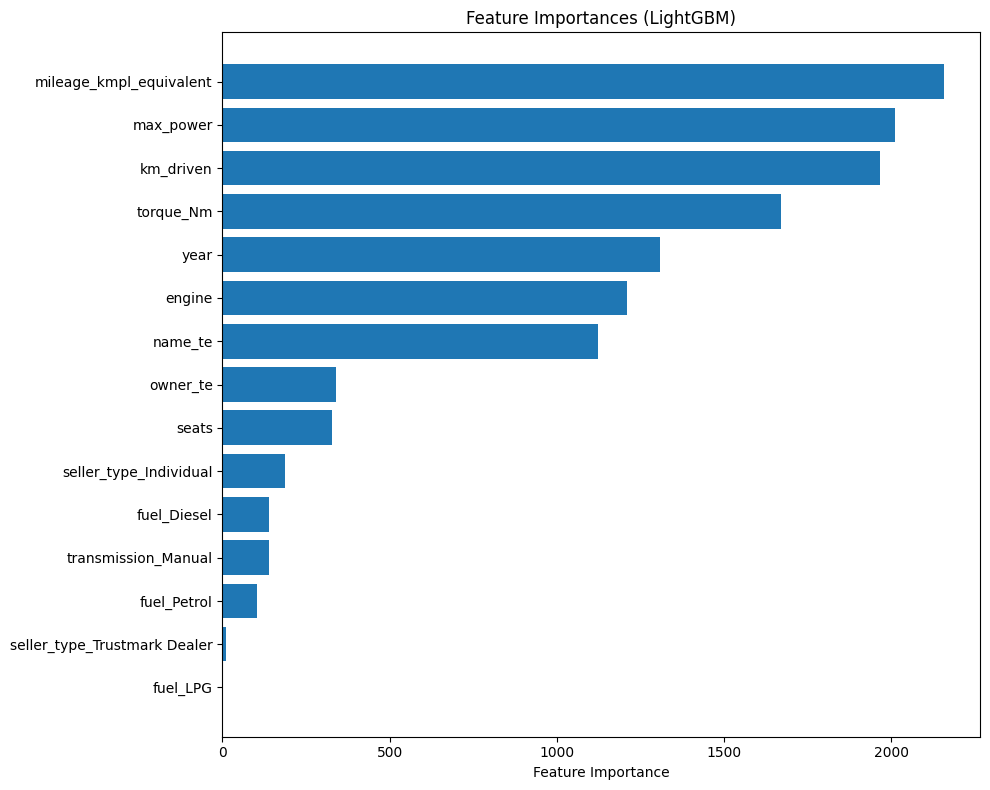

In [20]:

# ===== 9. Feature Importance và Visualization =====
# Huấn luyện lại model với all_features hoặc best_feats
pipe_imp = build_pipeline(all_features, params={**study.best_params, 'random_state': SEED, 'n_jobs': -1, 'verbose': -1})
pipe_imp.fit(train_df[all_features], train_df[target_variable])

lgb_model = pipe_imp.named_steps['model']
pre = pipe_imp.named_steps['pre']

# Tạo danh sách tên feature sau preprocessing
te_names = [col + '_te' for col in all_features if col in te_features]
ohe_names = list(pre.named_transformers_['ohe'].get_feature_names_out(encoded_features))
remainder = [col for col in all_features if col in numerical_cols]
feature_names = te_names + ohe_names + remainder

# Lấy importance và vẽ
importance_vals = lgb_model.feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importance_vals})
imp_df = imp_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()


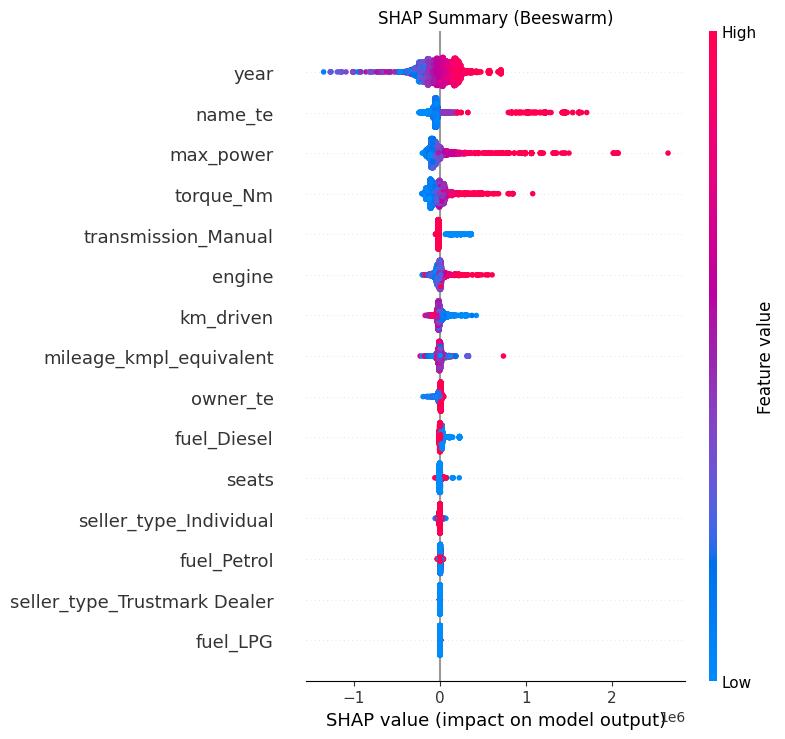

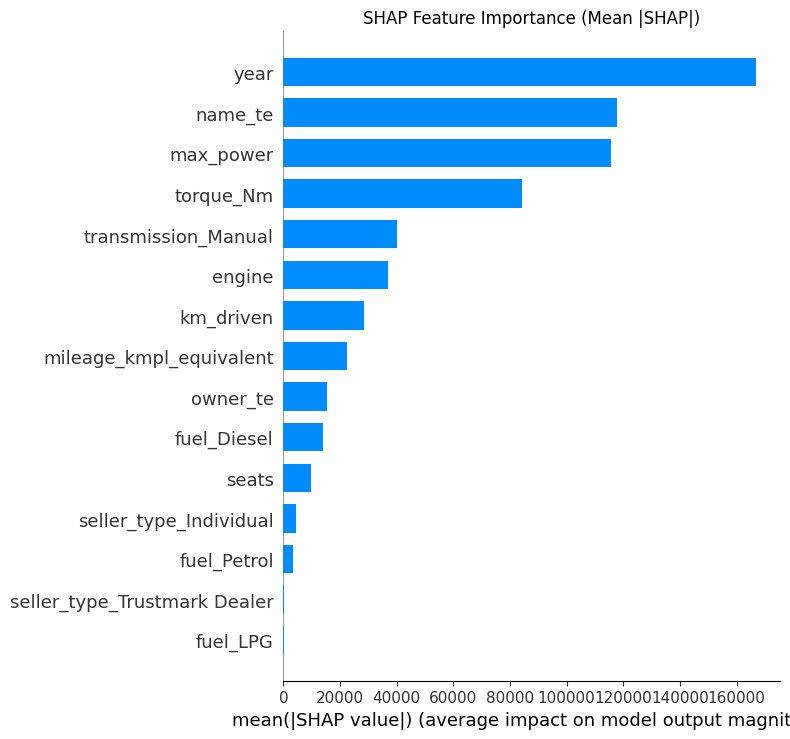

In [23]:
# ===== 10. SHAP Analysis =====
import shap
# Chuẩn bị data đã preprocessing
X_prepped = pre.transform(train_df[all_features])
explainer = shap.TreeExplainer(lgb_model)
shap_vals = explainer.shap_values(X_prepped)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_vals, X_prepped, feature_names=feature_names, show=False)
plt.title('SHAP Summary (Beeswarm)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_vals, X_prepped, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean |SHAP|)')
plt.tight_layout()
plt.show()

In [24]:
# ===== 11. Retrain với toàn bộ dữ liệu (full data, best_feats) và Optuna lại =====
X_full = df[best_feats]
y_full = df[target_variable]

sampler_full = optuna.samplers.TPESampler(seed=SEED)
study_full = optuna.create_study(direction='minimize', sampler=sampler_full)

def objective_full(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'random_state': SEED,
        'n_jobs': 1,
        'verbose': -1
    }
    pipe = build_pipeline(best_feats, params=params)
    return -cross_val_score(pipe, X_full, y_full, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()

study_full.optimize(objective_full, n_trials=100, show_progress_bar=True)
print('[FULL DATA] Best RMSE:', round(study_full.best_value, 2))
print('[FULL DATA] Best params:', study_full.best_params)


[I 2025-06-17 21:55:46,779] A new study created in memory with name: no-name-60a2bd52-920e-442b-b285-bbe43d3b417f
Best trial: 0. Best value: 130905:   1%|          | 1/100 [00:06<10:10,  6.17s/it]

[I 2025-06-17 21:55:53,002] Trial 0 finished with value: 130904.88291202202 and parameters: {'n_estimators': 749, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.2904180608409973}. Best is trial 0 with value: 130904.88291202202.


Best trial: 1. Best value: 128473:   2%|▏         | 2/100 [00:17<14:39,  8.98s/it]

[I 2025-06-17 21:56:03,963] Trial 1 finished with value: 128473.10573196341 and parameters: {'n_estimators': 1340, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.0616955533913808}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   3%|▎         | 3/100 [00:20<10:06,  6.25s/it]

[I 2025-06-17 21:56:06,910] Trial 2 finished with value: 142535.3394105655 and parameters: {'n_estimators': 518, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 1.4561457009902097, 'reg_lambda': 3.0592644736118975}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   4%|▍         | 4/100 [00:22<07:50,  4.91s/it]

[I 2025-06-17 21:56:09,760] Trial 3 finished with value: 137129.9234741688 and parameters: {'n_estimators': 467, 'max_depth': 6, 'learning_rate': 0.03476649150592621, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 0.9983689107917987, 'reg_lambda': 2.571172192068058}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   5%|▌         | 5/100 [00:25<06:29,  4.10s/it]

[I 2025-06-17 21:56:12,471] Trial 4 finished with value: 143793.82794693735 and parameters: {'n_estimators': 1011, 'max_depth': 3, 'learning_rate': 0.07896186801026692, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 4.7444276862666666, 'reg_lambda': 4.828160165372797}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   6%|▌         | 6/100 [00:32<08:06,  5.18s/it]

[I 2025-06-17 21:56:19,686] Trial 5 finished with value: 137958.39091835922 and parameters: {'n_estimators': 1270, 'max_depth': 6, 'learning_rate': 0.013940346079873234, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.6101911742238941, 'reg_lambda': 2.475884550556351}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   7%|▋         | 7/100 [00:35<06:49,  4.41s/it]

[I 2025-06-17 21:56:22,552] Trial 6 finished with value: 144093.76425414343 and parameters: {'n_estimators': 341, 'max_depth': 14, 'learning_rate': 0.024112898115291985, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 2.600340105889054, 'reg_lambda': 2.7335513967163982}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   8%|▊         | 8/100 [00:41<07:13,  4.72s/it]

[I 2025-06-17 21:56:27,784] Trial 7 finished with value: 132211.3406744024 and parameters: {'n_estimators': 522, 'max_depth': 15, 'learning_rate': 0.13962563737015762, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 2.9894998940554256, 'reg_lambda': 4.609371175115584}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:   9%|▉         | 9/100 [00:43<06:09,  4.07s/it]

[I 2025-06-17 21:56:30,585] Trial 8 finished with value: 158706.80489864244 and parameters: {'n_estimators': 406, 'max_depth': 5, 'learning_rate': 0.011662890273931383, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:  10%|█         | 10/100 [00:48<06:21,  4.24s/it]

[I 2025-06-17 21:56:35,215] Trial 9 finished with value: 133240.9436062986 and parameters: {'n_estimators': 728, 'max_depth': 6, 'learning_rate': 0.06333268775321843, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.3727532183988541, 'reg_lambda': 4.9344346830025865}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:  11%|█         | 11/100 [01:00<09:52,  6.66s/it]

[I 2025-06-17 21:56:47,223] Trial 10 finished with value: 135617.34048489327 and parameters: {'n_estimators': 1475, 'max_depth': 11, 'learning_rate': 0.2704729722717779, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8259332753890893, 'reg_alpha': 4.53832397641259, 'reg_lambda': 0.4044381318692345}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:  12%|█▏        | 12/100 [01:08<10:31,  7.17s/it]

[I 2025-06-17 21:56:55,693] Trial 11 finished with value: 133257.78146400448 and parameters: {'n_estimators': 950, 'max_depth': 11, 'learning_rate': 0.12322945413760499, 'subsample': 0.9294632818743329, 'colsample_bytree': 0.5046138345222255, 'reg_alpha': 3.530042849428194, 'reg_lambda': 0.19121386233135113}. Best is trial 1 with value: 128473.10573196341.


Best trial: 1. Best value: 128473:  13%|█▎        | 13/100 [01:20<12:14,  8.44s/it]

[I 2025-06-17 21:57:07,057] Trial 12 finished with value: 137358.99319292587 and parameters: {'n_estimators': 1202, 'max_depth': 12, 'learning_rate': 0.22514439322776278, 'subsample': 0.6822094348295599, 'colsample_bytree': 0.6010807595833223, 'reg_alpha': 3.7499293234807096, 'reg_lambda': 1.2919433164879133}. Best is trial 1 with value: 128473.10573196341.


Best trial: 13. Best value: 126666:  14%|█▍        | 14/100 [01:29<12:36,  8.79s/it]

[I 2025-06-17 21:57:16,660] Trial 13 finished with value: 126665.79977815403 and parameters: {'n_estimators': 737, 'max_depth': 9, 'learning_rate': 0.11633823680103778, 'subsample': 0.85058129769688, 'colsample_bytree': 0.9952180311738619, 'reg_alpha': 2.0059817139950247, 'reg_lambda': 1.1356950582543934}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  14%|█▍        | 14/100 [01:36<12:36,  8.79s/it]

[I 2025-06-17 21:57:22,550] Trial 14 finished with value: 128476.38290905864 and parameters: {'n_estimators': 724, 'max_depth': 9, 'learning_rate': 0.08462685130512262, 'subsample': 0.8933264051383842, 'colsample_bytree': 0.9777934309293094, 'reg_alpha': 1.932178558015394, 'reg_lambda': 1.414358045318778}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  16%|█▌        | 16/100 [01:47<12:42,  9.08s/it]

[I 2025-06-17 21:57:34,433] Trial 15 finished with value: 129019.10794969105 and parameters: {'n_estimators': 1123, 'max_depth': 9, 'learning_rate': 0.04865505635514485, 'subsample': 0.6325768968066001, 'colsample_bytree': 0.8168061550000413, 'reg_alpha': 2.067070498463565, 'reg_lambda': 1.341478271691825}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  17%|█▋        | 17/100 [01:59<13:55, 10.06s/it]

[I 2025-06-17 21:57:46,797] Trial 16 finished with value: 133184.0637785722 and parameters: {'n_estimators': 1392, 'max_depth': 8, 'learning_rate': 0.18660578854702625, 'subsample': 0.8805635105299408, 'colsample_bytree': 0.9986377504980908, 'reg_alpha': 3.9732268205604453, 'reg_lambda': 1.8698885287079225}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  18%|█▊        | 18/100 [02:07<12:52,  9.42s/it]

[I 2025-06-17 21:57:54,710] Trial 17 finished with value: 133228.4808828003 and parameters: {'n_estimators': 838, 'max_depth': 12, 'learning_rate': 0.16568183935112596, 'subsample': 0.502646518634279, 'colsample_bytree': 0.8043309663196494, 'reg_alpha': 3.3098880383531077, 'reg_lambda': 0.8554695451581789}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  19%|█▉        | 19/100 [02:12<10:41,  7.92s/it]

[I 2025-06-17 21:57:59,143] Trial 18 finished with value: 129901.30294980397 and parameters: {'n_estimators': 620, 'max_depth': 8, 'learning_rate': 0.09457692440469626, 'subsample': 0.7296194982784152, 'colsample_bytree': 0.9132477817274448, 'reg_alpha': 2.6809801644144797, 'reg_lambda': 2.007117617186149}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  20%|██        | 20/100 [02:19<10:18,  7.73s/it]

[I 2025-06-17 21:58:06,435] Trial 19 finished with value: 129429.1251213232 and parameters: {'n_estimators': 1058, 'max_depth': 10, 'learning_rate': 0.04560477572923572, 'subsample': 0.9746524736680412, 'colsample_bytree': 0.8542238305260478, 'reg_alpha': 2.180499167861401, 'reg_lambda': 0.8202776798861489}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  21%|██        | 21/100 [02:26<09:40,  7.35s/it]

[I 2025-06-17 21:58:12,884] Trial 20 finished with value: 136586.18739449215 and parameters: {'n_estimators': 884, 'max_depth': 13, 'learning_rate': 0.2971878477286393, 'subsample': 0.5721800280232665, 'colsample_bytree': 0.7752847229001598, 'reg_alpha': 0.0416511439828513, 'reg_lambda': 2.0183951235098516}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  22%|██▏       | 22/100 [02:29<08:11,  6.31s/it]

[I 2025-06-17 21:58:16,768] Trial 21 finished with value: 128307.09855738678 and parameters: {'n_estimators': 661, 'max_depth': 9, 'learning_rate': 0.0866189951076864, 'subsample': 0.8876525946361652, 'colsample_bytree': 0.9987410285929431, 'reg_alpha': 1.8973028109067687, 'reg_lambda': 1.1022477439206033}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  23%|██▎       | 23/100 [02:33<07:12,  5.62s/it]

[I 2025-06-17 21:58:20,779] Trial 22 finished with value: 130339.49953690809 and parameters: {'n_estimators': 643, 'max_depth': 8, 'learning_rate': 0.06620145989961654, 'subsample': 0.9061080132164645, 'colsample_bytree': 0.9530844099691923, 'reg_alpha': 1.7684726680627434, 'reg_lambda': 0.7292716560639948}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  24%|██▍       | 24/100 [02:38<06:39,  5.25s/it]

[I 2025-06-17 21:58:25,177] Trial 23 finished with value: 128698.69431333701 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.10374291346807847, 'subsample': 0.8519131515703272, 'colsample_bytree': 0.9955274152184259, 'reg_alpha': 4.255781824922331, 'reg_lambda': 1.6516897780543536}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  25%|██▌       | 25/100 [02:45<07:14,  5.80s/it]

[I 2025-06-17 21:58:32,256] Trial 24 finished with value: 132357.26556967484 and parameters: {'n_estimators': 819, 'max_depth': 7, 'learning_rate': 0.17180780808103696, 'subsample': 0.7962542485409149, 'colsample_bytree': 0.9370758204210594, 'reg_alpha': 2.903934907981659, 'reg_lambda': 1.0107893981272493}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  26%|██▌       | 26/100 [02:53<08:04,  6.55s/it]

[I 2025-06-17 21:58:40,563] Trial 25 finished with value: 130329.94396394577 and parameters: {'n_estimators': 921, 'max_depth': 10, 'learning_rate': 0.07439391155561208, 'subsample': 0.9312404495902853, 'colsample_bytree': 0.8722892359601168, 'reg_alpha': 4.996080755213512, 'reg_lambda': 3.8213465184657416}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  27%|██▋       | 27/100 [03:02<08:36,  7.08s/it]

[I 2025-06-17 21:58:48,857] Trial 26 finished with value: 127092.38238687153 and parameters: {'n_estimators': 1208, 'max_depth': 9, 'learning_rate': 0.10713723111016969, 'subsample': 0.9987349142404869, 'colsample_bytree': 0.9587696949484126, 'reg_alpha': 1.4077658162168274, 'reg_lambda': 0.5226922169484143}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  28%|██▊       | 28/100 [03:07<07:56,  6.61s/it]

[I 2025-06-17 21:58:54,379] Trial 27 finished with value: 130843.84578096634 and parameters: {'n_estimators': 1102, 'max_depth': 7, 'learning_rate': 0.05326686556385861, 'subsample': 0.9993881885961754, 'colsample_bytree': 0.9481594842197384, 'reg_alpha': 2.3058837788475617, 'reg_lambda': 0.5365790663871395}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  29%|██▉       | 29/100 [03:13<07:36,  6.43s/it]

[I 2025-06-17 21:59:00,377] Trial 28 finished with value: 132873.19143114984 and parameters: {'n_estimators': 784, 'max_depth': 9, 'learning_rate': 0.1450104720938838, 'subsample': 0.9438245048353373, 'colsample_bytree': 0.917472119257295, 'reg_alpha': 1.4623436103328287, 'reg_lambda': 0.07770076351869071}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  30%|███       | 30/100 [03:18<07:00,  6.00s/it]

[I 2025-06-17 21:59:05,399] Trial 29 finished with value: 130058.35984321844 and parameters: {'n_estimators': 684, 'max_depth': 11, 'learning_rate': 0.040711275905732994, 'subsample': 0.7750428543412011, 'colsample_bytree': 0.8606457724793473, 'reg_alpha': 1.08806613550985, 'reg_lambda': 0.4272214637832179}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  31%|███       | 31/100 [03:25<07:10,  6.24s/it]

[I 2025-06-17 21:59:12,191] Trial 30 finished with value: 132770.6768072523 and parameters: {'n_estimators': 989, 'max_depth': 7, 'learning_rate': 0.21632462248901638, 'subsample': 0.8682271204479801, 'colsample_bytree': 0.9650358309853261, 'reg_alpha': 1.6951609201399185, 'reg_lambda': 3.288532787998743}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  32%|███▏      | 32/100 [03:35<08:32,  7.54s/it]

[I 2025-06-17 21:59:22,784] Trial 31 finished with value: 128889.00160671161 and parameters: {'n_estimators': 1362, 'max_depth': 9, 'learning_rate': 0.11324254215074069, 'subsample': 0.8248555772266066, 'colsample_bytree': 0.9882484124446536, 'reg_alpha': 2.336537717026654, 'reg_lambda': 1.1393464185534432}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  33%|███▎      | 33/100 [03:44<08:38,  7.74s/it]

[I 2025-06-17 21:59:30,983] Trial 32 finished with value: 131522.53015506273 and parameters: {'n_estimators': 1274, 'max_depth': 10, 'learning_rate': 0.10476818776475046, 'subsample': 0.8048139549758966, 'colsample_bytree': 0.9259728530388712, 'reg_alpha': 1.1363083651714816, 'reg_lambda': 0.02043979485942171}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  34%|███▍      | 34/100 [03:54<09:23,  8.53s/it]

[I 2025-06-17 21:59:41,369] Trial 33 finished with value: 130263.04121282804 and parameters: {'n_estimators': 1447, 'max_depth': 12, 'learning_rate': 0.1339443292794039, 'subsample': 0.9969438596180498, 'colsample_bytree': 0.967415376406153, 'reg_alpha': 1.6066455487015174, 'reg_lambda': 0.6430403734429937}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  35%|███▌      | 35/100 [04:02<09:06,  8.41s/it]

[I 2025-06-17 21:59:49,499] Trial 34 finished with value: 129666.42014152443 and parameters: {'n_estimators': 1299, 'max_depth': 8, 'learning_rate': 0.09027815391064122, 'subsample': 0.7407736309511672, 'colsample_bytree': 0.8882039772518461, 'reg_alpha': 3.206010877469909, 'reg_lambda': 1.6169945302835869}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  36%|███▌      | 36/100 [04:04<06:51,  6.42s/it]

[I 2025-06-17 21:59:51,283] Trial 35 finished with value: 145768.09872267197 and parameters: {'n_estimators': 523, 'max_depth': 3, 'learning_rate': 0.06184351819077576, 'subsample': 0.6986396182085534, 'colsample_bytree': 0.9995785103610629, 'reg_alpha': 0.8165880005180577, 'reg_lambda': 1.0297121346139542}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  37%|███▋      | 37/100 [04:12<07:22,  7.02s/it]

[I 2025-06-17 21:59:59,698] Trial 36 finished with value: 130841.11323027285 and parameters: {'n_estimators': 1177, 'max_depth': 11, 'learning_rate': 0.02494568448170895, 'subsample': 0.9101320728802789, 'colsample_bytree': 0.9621831130296441, 'reg_alpha': 1.9373335938103022, 'reg_lambda': 2.2937021316344124}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  38%|███▊      | 38/100 [04:20<07:34,  7.33s/it]

[I 2025-06-17 22:00:07,763] Trial 37 finished with value: 130055.92542169304 and parameters: {'n_estimators': 1346, 'max_depth': 9, 'learning_rate': 0.08476080620183563, 'subsample': 0.7690854425698334, 'colsample_bytree': 0.9385400167330109, 'reg_alpha': 2.7167512664363236, 'reg_lambda': 1.5805260261479148}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  39%|███▉      | 39/100 [04:28<07:27,  7.33s/it]

[I 2025-06-17 22:00:15,086] Trial 38 finished with value: 133400.48105609795 and parameters: {'n_estimators': 1195, 'max_depth': 10, 'learning_rate': 0.016827752123288398, 'subsample': 0.9595783057961501, 'colsample_bytree': 0.8902988256440694, 'reg_alpha': 1.2416527920885139, 'reg_lambda': 3.0029094746249885}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  40%|████      | 40/100 [04:30<05:48,  5.80s/it]

[I 2025-06-17 22:00:17,327] Trial 39 finished with value: 136017.22198591213 and parameters: {'n_estimators': 563, 'max_depth': 5, 'learning_rate': 0.07144245659507367, 'subsample': 0.6348699307637369, 'colsample_bytree': 0.7460600767918331, 'reg_alpha': 2.4647775650130845, 'reg_lambda': 2.248527778619658}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  41%|████      | 41/100 [04:34<05:04,  5.15s/it]

[I 2025-06-17 22:00:20,580] Trial 40 finished with value: 135607.08551785751 and parameters: {'n_estimators': 420, 'max_depth': 13, 'learning_rate': 0.03609780210821854, 'subsample': 0.8588661762831937, 'colsample_bytree': 0.621757277239386, 'reg_alpha': 0.7425393060100791, 'reg_lambda': 0.3309679713375685}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  42%|████▏     | 42/100 [04:39<05:07,  5.30s/it]

[I 2025-06-17 22:00:26,610] Trial 41 finished with value: 127473.5430555994 and parameters: {'n_estimators': 736, 'max_depth': 9, 'learning_rate': 0.0822718376086045, 'subsample': 0.8971991702159879, 'colsample_bytree': 0.9723654278846712, 'reg_alpha': 1.8922524254358626, 'reg_lambda': 1.3639604159923975}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  43%|████▎     | 43/100 [04:45<05:12,  5.47s/it]

[I 2025-06-17 22:00:32,473] Trial 42 finished with value: 127471.86783812653 and parameters: {'n_estimators': 672, 'max_depth': 8, 'learning_rate': 0.11965849399052463, 'subsample': 0.9176391031609291, 'colsample_bytree': 0.9723157939376, 'reg_alpha': 1.5386683937043206, 'reg_lambda': 1.1729378834853073}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  44%|████▍     | 44/100 [04:48<04:27,  4.78s/it]

[I 2025-06-17 22:00:35,647] Trial 43 finished with value: 130093.94045118049 and parameters: {'n_estimators': 677, 'max_depth': 7, 'learning_rate': 0.14910010019090306, 'subsample': 0.9123386201928337, 'colsample_bytree': 0.975419047477103, 'reg_alpha': 1.5100304642214315, 'reg_lambda': 1.1673574843507397}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  45%|████▌     | 45/100 [04:53<04:20,  4.74s/it]

[I 2025-06-17 22:00:40,288] Trial 44 finished with value: 131363.26810857962 and parameters: {'n_estimators': 740, 'max_depth': 8, 'learning_rate': 0.1237155033074269, 'subsample': 0.9536597920604916, 'colsample_bytree': 0.9204252441233521, 'reg_alpha': 1.8370362848810466, 'reg_lambda': 0.880089697163265}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  46%|████▌     | 46/100 [04:56<03:49,  4.25s/it]

[I 2025-06-17 22:00:43,406] Trial 45 finished with value: 131382.452414971 and parameters: {'n_estimators': 799, 'max_depth': 6, 'learning_rate': 0.10128637907117125, 'subsample': 0.8907641629993646, 'colsample_bytree': 0.97308476853478, 'reg_alpha': 0.911834883005622, 'reg_lambda': 1.8631981781200557}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  47%|████▋     | 47/100 [05:00<03:45,  4.26s/it]

[I 2025-06-17 22:00:47,700] Trial 46 finished with value: 128474.65970092613 and parameters: {'n_estimators': 858, 'max_depth': 9, 'learning_rate': 0.05863830202548577, 'subsample': 0.9755157054636671, 'colsample_bytree': 0.9358158718233359, 'reg_alpha': 2.1027322704065803, 'reg_lambda': 1.441492873529964}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  48%|████▊     | 48/100 [05:03<03:12,  3.69s/it]

[I 2025-06-17 22:00:50,054] Trial 47 finished with value: 132508.30765658023 and parameters: {'n_estimators': 485, 'max_depth': 8, 'learning_rate': 0.20544926660482388, 'subsample': 0.8335837377354568, 'colsample_bytree': 0.9012414479298528, 'reg_alpha': 1.2182976089225455, 'reg_lambda': 0.614271656464473}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  49%|████▉     | 49/100 [05:04<02:38,  3.11s/it]

[I 2025-06-17 22:00:51,818] Trial 48 finished with value: 130467.88019340925 and parameters: {'n_estimators': 309, 'max_depth': 11, 'learning_rate': 0.11295478918424581, 'subsample': 0.9341777827104082, 'colsample_bytree': 0.8386439026458409, 'reg_alpha': 1.6186154178931178, 'reg_lambda': 1.1907320807165163}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  50%|█████     | 50/100 [05:08<02:37,  3.16s/it]

[I 2025-06-17 22:00:55,081] Trial 49 finished with value: 131416.08771544843 and parameters: {'n_estimators': 766, 'max_depth': 7, 'learning_rate': 0.07368557922161775, 'subsample': 0.8705144569042891, 'colsample_bytree': 0.658910470147277, 'reg_alpha': 1.3884996887360905, 'reg_lambda': 0.3120222135020736}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  51%|█████     | 51/100 [05:11<02:32,  3.11s/it]

[I 2025-06-17 22:00:58,082] Trial 50 finished with value: 129335.46313273143 and parameters: {'n_estimators': 563, 'max_depth': 9, 'learning_rate': 0.08446812701123968, 'subsample': 0.8145071378577258, 'colsample_bytree': 0.9535547652976323, 'reg_alpha': 0.5824039482660699, 'reg_lambda': 1.7678051362451088}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  52%|█████▏    | 52/100 [05:15<02:45,  3.44s/it]

[I 2025-06-17 22:01:02,283] Trial 51 finished with value: 127448.55665024868 and parameters: {'n_estimators': 669, 'max_depth': 10, 'learning_rate': 0.1273032865927585, 'subsample': 0.5238103711073023, 'colsample_bytree': 0.9803114354376159, 'reg_alpha': 2.1329482393099246, 'reg_lambda': 0.9564073757541386}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  53%|█████▎    | 53/100 [05:22<03:30,  4.49s/it]

[I 2025-06-17 22:01:09,219] Trial 52 finished with value: 129129.31278171288 and parameters: {'n_estimators': 677, 'max_depth': 10, 'learning_rate': 0.15877303099377105, 'subsample': 0.525046064422955, 'colsample_bytree': 0.9989501639681181, 'reg_alpha': 2.1008160815412245, 'reg_lambda': 0.9493893999931482}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  54%|█████▍    | 54/100 [05:26<03:17,  4.29s/it]

[I 2025-06-17 22:01:13,010] Trial 53 finished with value: 128913.6618347737 and parameters: {'n_estimators': 637, 'max_depth': 8, 'learning_rate': 0.12872385206748593, 'subsample': 0.5356725856964797, 'colsample_bytree': 0.9791015010444726, 'reg_alpha': 2.32300740170092, 'reg_lambda': 1.475706500122794}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  55%|█████▌    | 55/100 [05:30<03:15,  4.34s/it]

[I 2025-06-17 22:01:17,508] Trial 54 finished with value: 130454.87993505699 and parameters: {'n_estimators': 731, 'max_depth': 10, 'learning_rate': 0.11712730218180095, 'subsample': 0.9207712928094252, 'colsample_bytree': 0.9528296639010903, 'reg_alpha': 2.5405872476350653, 'reg_lambda': 1.259340333109725}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  56%|█████▌    | 56/100 [05:34<03:00,  4.11s/it]

[I 2025-06-17 22:01:21,088] Trial 55 finished with value: 127426.21455866579 and parameters: {'n_estimators': 574, 'max_depth': 9, 'learning_rate': 0.09592323323382346, 'subsample': 0.8877035180177395, 'colsample_bytree': 0.9834436600464643, 'reg_alpha': 1.9585532231937088, 'reg_lambda': 0.7418393531208087}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  57%|█████▋    | 57/100 [05:37<02:43,  3.80s/it]

[I 2025-06-17 22:01:24,092] Trial 56 finished with value: 129239.60925475406 and parameters: {'n_estimators': 430, 'max_depth': 11, 'learning_rate': 0.24306760125650667, 'subsample': 0.8523625350686376, 'colsample_bytree': 0.9802324515872813, 'reg_alpha': 2.0162898930518987, 'reg_lambda': 0.7204604551891108}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  58%|█████▊    | 58/100 [05:39<02:21,  3.37s/it]

[I 2025-06-17 22:01:26,523] Trial 57 finished with value: 133273.67834445738 and parameters: {'n_estimators': 579, 'max_depth': 6, 'learning_rate': 0.17712759116221707, 'subsample': 0.9783144880972567, 'colsample_bytree': 0.9098064035862127, 'reg_alpha': 1.7407173066454025, 'reg_lambda': 0.4656677336560491}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  59%|█████▉    | 59/100 [05:41<02:03,  3.00s/it]

[I 2025-06-17 22:01:28,676] Trial 58 finished with value: 136359.22699709423 and parameters: {'n_estimators': 709, 'max_depth': 4, 'learning_rate': 0.09951593020869569, 'subsample': 0.6025785520535363, 'colsample_bytree': 0.9315941029066255, 'reg_alpha': 2.9197578962549775, 'reg_lambda': 0.16766043265199093}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  60%|██████    | 60/100 [05:45<02:07,  3.19s/it]

[I 2025-06-17 22:01:32,295] Trial 59 finished with value: 132619.33091270618 and parameters: {'n_estimators': 504, 'max_depth': 9, 'learning_rate': 0.14001867099272688, 'subsample': 0.7029633135171226, 'colsample_bytree': 0.8716428480294045, 'reg_alpha': 2.231474252822183, 'reg_lambda': 0.7728809516052322}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  61%|██████    | 61/100 [05:50<02:30,  3.85s/it]

[I 2025-06-17 22:01:37,703] Trial 60 finished with value: 135982.46628895076 and parameters: {'n_estimators': 907, 'max_depth': 8, 'learning_rate': 0.1934115408406983, 'subsample': 0.7912313289630337, 'colsample_bytree': 0.7921722475066958, 'reg_alpha': 1.3120569177102808, 'reg_lambda': 1.3401016545885613}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  62%|██████▏   | 62/100 [05:54<02:25,  3.84s/it]

[I 2025-06-17 22:01:41,509] Trial 61 finished with value: 128258.64416905481 and parameters: {'n_estimators': 645, 'max_depth': 9, 'learning_rate': 0.0909235293022065, 'subsample': 0.8955211131613551, 'colsample_bytree': 0.9831642234101017, 'reg_alpha': 1.919108636638151, 'reg_lambda': 1.0002412806181287}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  63%|██████▎   | 63/100 [05:58<02:19,  3.76s/it]

[I 2025-06-17 22:01:45,082] Trial 62 finished with value: 131767.9730117196 and parameters: {'n_estimators': 636, 'max_depth': 10, 'learning_rate': 0.09363601247690582, 'subsample': 0.8954730482143616, 'colsample_bytree': 0.5534708392316988, 'reg_alpha': 1.8732721589182844, 'reg_lambda': 0.9308843909236463}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  64%|██████▍   | 64/100 [06:02<02:23,  3.98s/it]

[I 2025-06-17 22:01:49,567] Trial 63 finished with value: 127282.7153208564 and parameters: {'n_estimators': 767, 'max_depth': 9, 'learning_rate': 0.07802489770613062, 'subsample': 0.9489230819177881, 'colsample_bytree': 0.958802878867613, 'reg_alpha': 1.4958320037507826, 'reg_lambda': 0.52078818839698}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  65%|██████▌   | 65/100 [06:07<02:28,  4.23s/it]

[I 2025-06-17 22:01:54,385] Trial 64 finished with value: 127908.58311959976 and parameters: {'n_estimators': 854, 'max_depth': 8, 'learning_rate': 0.07919577034818594, 'subsample': 0.9426475713846533, 'colsample_bytree': 0.9587057789950193, 'reg_alpha': 1.6348935563439282, 'reg_lambda': 0.5701164523707271}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  66%|██████▌   | 66/100 [06:13<02:39,  4.69s/it]

[I 2025-06-17 22:02:00,147] Trial 65 finished with value: 128950.9674761175 and parameters: {'n_estimators': 956, 'max_depth': 10, 'learning_rate': 0.06630406333508135, 'subsample': 0.9887147757723491, 'colsample_bytree': 0.9438377057940185, 'reg_alpha': 1.4731032136135374, 'reg_lambda': 0.3008721424007006}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  67%|██████▋   | 67/100 [06:18<02:35,  4.72s/it]

[I 2025-06-17 22:02:04,937] Trial 66 finished with value: 128467.05909643113 and parameters: {'n_estimators': 773, 'max_depth': 9, 'learning_rate': 0.05274665953353707, 'subsample': 0.9664845091461346, 'colsample_bytree': 0.9664530873970196, 'reg_alpha': 1.0125603784102903, 'reg_lambda': 0.7190281629951296}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  68%|██████▊   | 68/100 [06:23<02:34,  4.83s/it]

[I 2025-06-17 22:02:10,012] Trial 67 finished with value: 128081.87623581858 and parameters: {'n_estimators': 812, 'max_depth': 9, 'learning_rate': 0.11173460477722923, 'subsample': 0.9227267902575393, 'colsample_bytree': 0.9848530762229787, 'reg_alpha': 2.4405820421765227, 'reg_lambda': 0.5155707716567454}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  69%|██████▉   | 69/100 [06:26<02:11,  4.25s/it]

[I 2025-06-17 22:02:12,912] Trial 68 finished with value: 130486.15030809787 and parameters: {'n_estimators': 599, 'max_depth': 7, 'learning_rate': 0.07732276778446483, 'subsample': 0.9507345260222806, 'colsample_bytree': 0.9295598168935185, 'reg_alpha': 2.7236940020921425, 'reg_lambda': 0.1512903296417326}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  70%|███████   | 70/100 [06:30<02:11,  4.39s/it]

[I 2025-06-17 22:02:17,627] Trial 69 finished with value: 131287.73131295055 and parameters: {'n_estimators': 700, 'max_depth': 11, 'learning_rate': 0.15462829677805004, 'subsample': 0.8418605861885187, 'colsample_bytree': 0.900877720872206, 'reg_alpha': 2.194827057459157, 'reg_lambda': 4.598870809555586}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  71%|███████   | 71/100 [06:34<02:04,  4.28s/it]

[I 2025-06-17 22:02:21,625] Trial 70 finished with value: 131208.60170827134 and parameters: {'n_estimators': 752, 'max_depth': 8, 'learning_rate': 0.12131468697616013, 'subsample': 0.8739178906890291, 'colsample_bytree': 0.943393234765112, 'reg_alpha': 1.752259339639679, 'reg_lambda': 1.1189120451615346}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  72%|███████▏  | 72/100 [06:40<02:10,  4.67s/it]

[I 2025-06-17 22:02:27,245] Trial 71 finished with value: 128005.08799026915 and parameters: {'n_estimators': 856, 'max_depth': 8, 'learning_rate': 0.0820847006952615, 'subsample': 0.9424679291552341, 'colsample_bytree': 0.9593081745511393, 'reg_alpha': 1.598096011939749, 'reg_lambda': 0.5798574492891745}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  73%|███████▎  | 73/100 [06:45<02:11,  4.86s/it]

[I 2025-06-17 22:02:32,523] Trial 72 finished with value: 126912.04414161225 and parameters: {'n_estimators': 877, 'max_depth': 10, 'learning_rate': 0.06721889521951978, 'subsample': 0.9346813974003114, 'colsample_bytree': 0.9662351457456344, 'reg_alpha': 1.3988990436018323, 'reg_lambda': 0.8331798637382899}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  74%|███████▍  | 74/100 [06:49<01:54,  4.41s/it]

[I 2025-06-17 22:02:35,888] Trial 73 finished with value: 129737.46098530144 and parameters: {'n_estimators': 526, 'max_depth': 10, 'learning_rate': 0.045433058147076204, 'subsample': 0.9134104960159055, 'colsample_bytree': 0.9877080607466573, 'reg_alpha': 1.3593493070863416, 'reg_lambda': 0.8735071223337718}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  75%|███████▌  | 75/100 [06:55<02:04,  4.98s/it]

[I 2025-06-17 22:02:42,204] Trial 74 finished with value: 128201.9279994753 and parameters: {'n_estimators': 1010, 'max_depth': 9, 'learning_rate': 0.10175960066234856, 'subsample': 0.9833053171978203, 'colsample_bytree': 0.9666702288574225, 'reg_alpha': 1.087201415860569, 'reg_lambda': 0.41093816017105433}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  76%|███████▌  | 76/100 [07:00<01:59,  4.98s/it]

[I 2025-06-17 22:02:47,186] Trial 75 finished with value: 129198.04134346561 and parameters: {'n_estimators': 828, 'max_depth': 10, 'learning_rate': 0.0720689316556738, 'subsample': 0.9655523480326755, 'colsample_bytree': 0.9211746052537841, 'reg_alpha': 2.060497926180451, 'reg_lambda': 1.2693768110233625}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  77%|███████▋  | 77/100 [07:07<02:08,  5.60s/it]

[I 2025-06-17 22:02:54,233] Trial 76 finished with value: 127912.86130923123 and parameters: {'n_estimators': 960, 'max_depth': 11, 'learning_rate': 0.06756428645101348, 'subsample': 0.935688095597931, 'colsample_bytree': 0.99059760600575, 'reg_alpha': 1.492086730107889, 'reg_lambda': 1.5291824679140162}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  78%|███████▊  | 78/100 [07:13<02:04,  5.67s/it]

[I 2025-06-17 22:03:00,082] Trial 77 finished with value: 128918.67667013248 and parameters: {'n_estimators': 886, 'max_depth': 12, 'learning_rate': 0.05647156897645074, 'subsample': 0.9019288066852852, 'colsample_bytree': 0.9518932492963631, 'reg_alpha': 1.2274433133182412, 'reg_lambda': 1.0588956771668547}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  79%|███████▉  | 79/100 [07:19<02:02,  5.85s/it]

[I 2025-06-17 22:03:06,347] Trial 78 finished with value: 129437.29961639794 and parameters: {'n_estimators': 1065, 'max_depth': 9, 'learning_rate': 0.1318076539416085, 'subsample': 0.8777539178547126, 'colsample_bytree': 0.9727824901059804, 'reg_alpha': 0.3878849648984095, 'reg_lambda': 0.818958777260756}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  80%|████████  | 80/100 [07:23<01:46,  5.31s/it]

[I 2025-06-17 22:03:10,386] Trial 79 finished with value: 129389.39083147023 and parameters: {'n_estimators': 718, 'max_depth': 9, 'learning_rate': 0.10758486826801444, 'subsample': 0.9982672034634056, 'colsample_bytree': 0.6874996804858278, 'reg_alpha': 1.7555032829335202, 'reg_lambda': 1.7311921872563576}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  81%|████████  | 81/100 [07:27<01:31,  4.81s/it]

[I 2025-06-17 22:03:14,032] Trial 80 finished with value: 131219.641229799 and parameters: {'n_estimators': 610, 'max_depth': 10, 'learning_rate': 0.09062479145347546, 'subsample': 0.9277257271506643, 'colsample_bytree': 0.8814458397046494, 'reg_alpha': 0.915704168451386, 'reg_lambda': 0.6895394342710541}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  82%|████████▏ | 82/100 [07:31<01:22,  4.57s/it]

[I 2025-06-17 22:03:18,061] Trial 81 finished with value: 127399.69747396992 and parameters: {'n_estimators': 785, 'max_depth': 8, 'learning_rate': 0.07781130960848792, 'subsample': 0.9468515449474664, 'colsample_bytree': 0.9592011769513378, 'reg_alpha': 1.6186104833600186, 'reg_lambda': 0.5627937937841375}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  83%|████████▎ | 83/100 [07:35<01:18,  4.64s/it]

[I 2025-06-17 22:03:22,826] Trial 82 finished with value: 129634.73796761571 and parameters: {'n_estimators': 929, 'max_depth': 8, 'learning_rate': 0.06128919342006932, 'subsample': 0.9557022307710007, 'colsample_bytree': 0.9445022515161348, 'reg_alpha': 1.9829519073713389, 'reg_lambda': 0.40933121792787663}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  84%|████████▍ | 84/100 [07:39<01:09,  4.36s/it]

[I 2025-06-17 22:03:26,559] Trial 83 finished with value: 128910.25836973113 and parameters: {'n_estimators': 791, 'max_depth': 7, 'learning_rate': 0.07999516956336387, 'subsample': 0.883298580970814, 'colsample_bytree': 0.9977629496209246, 'reg_alpha': 1.5450309920918839, 'reg_lambda': 0.006187024953293041}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  85%|████████▌ | 85/100 [07:43<01:03,  4.26s/it]

[I 2025-06-17 22:03:30,581] Trial 84 finished with value: 128609.86651605836 and parameters: {'n_estimators': 755, 'max_depth': 9, 'learning_rate': 0.09612152674124257, 'subsample': 0.9036912234939753, 'colsample_bytree': 0.9720722573236645, 'reg_alpha': 1.8440028180716423, 'reg_lambda': 1.3833453175150279}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  86%|████████▌ | 86/100 [07:48<01:03,  4.53s/it]

[I 2025-06-17 22:03:35,744] Trial 85 finished with value: 128165.78850463447 and parameters: {'n_estimators': 695, 'max_depth': 15, 'learning_rate': 0.049268766838759595, 'subsample': 0.8655923029051286, 'colsample_bytree': 0.9318246487224237, 'reg_alpha': 1.313767376111482, 'reg_lambda': 0.26759233086557865}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  87%|████████▋ | 87/100 [07:52<00:56,  4.38s/it]

[I 2025-06-17 22:03:39,768] Trial 86 finished with value: 130037.90132559976 and parameters: {'n_estimators': 797, 'max_depth': 8, 'learning_rate': 0.067544980769041, 'subsample': 0.9223624363760978, 'colsample_bytree': 0.9162628062557495, 'reg_alpha': 1.426723588755463, 'reg_lambda': 0.8364153345067817}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  88%|████████▊ | 88/100 [07:57<00:55,  4.58s/it]

[I 2025-06-17 22:03:44,837] Trial 87 finished with value: 141639.76698903987 and parameters: {'n_estimators': 669, 'max_depth': 9, 'learning_rate': 0.010004078539318182, 'subsample': 0.9676131014552324, 'colsample_bytree': 0.9604033535766621, 'reg_alpha': 1.6568613492463027, 'reg_lambda': 0.9761003297644544}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  89%|████████▉ | 89/100 [08:02<00:50,  4.63s/it]

[I 2025-06-17 22:03:49,573] Trial 88 finished with value: 130101.53015837884 and parameters: {'n_estimators': 744, 'max_depth': 10, 'learning_rate': 0.12312796580734747, 'subsample': 0.9452355760609832, 'colsample_bytree': 0.9853406323626721, 'reg_alpha': 2.1327194279370563, 'reg_lambda': 3.6305736458729196}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  90%|█████████ | 90/100 [08:07<00:46,  4.67s/it]

[I 2025-06-17 22:03:54,342] Trial 89 finished with value: 129717.19093058351 and parameters: {'n_estimators': 885, 'max_depth': 8, 'learning_rate': 0.1395057172148184, 'subsample': 0.6620889614141734, 'colsample_bytree': 0.9724653890645331, 'reg_alpha': 1.1205725327636045, 'reg_lambda': 0.6565348225649517}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  91%|█████████ | 91/100 [08:11<00:41,  4.59s/it]

[I 2025-06-17 22:03:58,734] Trial 90 finished with value: 129446.61734121072 and parameters: {'n_estimators': 833, 'max_depth': 9, 'learning_rate': 0.10615615496887695, 'subsample': 0.9179223575627731, 'colsample_bytree': 0.9439457814826981, 'reg_alpha': 2.363900173545592, 'reg_lambda': 2.053153355998029}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  92%|█████████▏| 92/100 [08:15<00:35,  4.42s/it]

[I 2025-06-17 22:04:02,766] Trial 91 finished with value: 129221.37023879464 and parameters: {'n_estimators': 840, 'max_depth': 7, 'learning_rate': 0.08133123908199776, 'subsample': 0.9414332669547075, 'colsample_bytree': 0.9576046119275825, 'reg_alpha': 1.6650661972032776, 'reg_lambda': 0.5584000316071818}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  93%|█████████▎| 93/100 [08:20<00:30,  4.37s/it]

[I 2025-06-17 22:04:07,022] Trial 92 finished with value: 130307.68498959669 and parameters: {'n_estimators': 862, 'max_depth': 8, 'learning_rate': 0.07473174636881261, 'subsample': 0.9579682001600125, 'colsample_bytree': 0.9064207142803841, 'reg_alpha': 1.8251029163454775, 'reg_lambda': 1.2022282537704547}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  94%|█████████▍| 94/100 [08:24<00:25,  4.27s/it]

[I 2025-06-17 22:04:11,051] Trial 93 finished with value: 128495.97927174317 and parameters: {'n_estimators': 779, 'max_depth': 8, 'learning_rate': 0.08811064258430784, 'subsample': 0.9315299208564269, 'colsample_bytree': 0.9590751949205529, 'reg_alpha': 1.5237688048884548, 'reg_lambda': 0.5037860746394793}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  95%|█████████▌| 95/100 [08:27<00:20,  4.12s/it]

[I 2025-06-17 22:04:14,833] Trial 94 finished with value: 131234.7664867625 and parameters: {'n_estimators': 657, 'max_depth': 9, 'learning_rate': 0.06155726858818933, 'subsample': 0.9863181830535286, 'colsample_bytree': 0.9885920600221948, 'reg_alpha': 1.9828325459766412, 'reg_lambda': 2.7787324497604415}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  96%|█████████▌| 96/100 [08:33<00:17,  4.47s/it]

[I 2025-06-17 22:04:20,103] Trial 95 finished with value: 127460.46348401457 and parameters: {'n_estimators': 722, 'max_depth': 10, 'learning_rate': 0.10085054865502012, 'subsample': 0.7527729621613326, 'colsample_bytree': 0.9773029364930079, 'reg_alpha': 1.7140691033851845, 'reg_lambda': 0.22543147101790045}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  97%|█████████▋| 97/100 [08:38<00:13,  4.60s/it]

[I 2025-06-17 22:04:25,013] Trial 96 finished with value: 127890.49220493114 and parameters: {'n_estimators': 716, 'max_depth': 10, 'learning_rate': 0.0983142072110995, 'subsample': 0.7391918517425073, 'colsample_bytree': 0.9810226567891276, 'reg_alpha': 1.2559872747530836, 'reg_lambda': 0.1802889714921444}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  98%|█████████▊| 98/100 [08:41<00:08,  4.26s/it]

[I 2025-06-17 22:04:28,497] Trial 97 finished with value: 130016.65451160185 and parameters: {'n_estimators': 554, 'max_depth': 10, 'learning_rate': 0.11043348341935247, 'subsample': 0.7173017993988708, 'colsample_bytree': 0.9275622448607967, 'reg_alpha': 2.2351015190693606, 'reg_lambda': 0.2831175822880401}. Best is trial 13 with value: 126665.79977815403.


Best trial: 13. Best value: 126666:  99%|█████████▉| 99/100 [08:45<00:04,  4.29s/it]

[I 2025-06-17 22:04:32,842] Trial 98 finished with value: 126777.36196381268 and parameters: {'n_estimators': 621, 'max_depth': 11, 'learning_rate': 0.11777030249967751, 'subsample': 0.7542843829944491, 'colsample_bytree': 0.9730858488890041, 'reg_alpha': 1.4030000238072942, 'reg_lambda': 0.7576455227051604}. Best is trial 13 with value: 126665.79977815403.


Best trial: 99. Best value: 126546: 100%|██████████| 100/100 [08:50<00:00,  5.30s/it]

[I 2025-06-17 22:04:37,140] Trial 99 finished with value: 126546.37452055879 and parameters: {'n_estimators': 616, 'max_depth': 11, 'learning_rate': 0.12951493140989137, 'subsample': 0.7655475991118137, 'colsample_bytree': 0.9964157345396858, 'reg_alpha': 1.3889153397632954, 'reg_lambda': 0.37659246717678974}. Best is trial 99 with value: 126546.37452055879.
[FULL DATA] Best RMSE: 126546.37
[FULL DATA] Best params: {'n_estimators': 616, 'max_depth': 11, 'learning_rate': 0.12951493140989137, 'subsample': 0.7655475991118137, 'colsample_bytree': 0.9964157345396858, 'reg_alpha': 1.3889153397632954, 'reg_lambda': 0.37659246717678974}


In [25]:

# ===== 12. Huấn luyện final model trên toàn bộ dữ liệu =====
final_model_full = build_pipeline(best_feats, params={**study_full.best_params, 'random_state': SEED, 'n_jobs': -1, 'verbose': -1})
final_model_full.fit(X_full, y_full)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  TargetEncoderSmooth(cols=['name',
                                                                            'owner']),
                                                  ['name', 'owner']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['fuel', 'transmission'])])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.9964157345396858,
                               learning_rate=0.12951493140989137, max_depth=11,
                               n_estimators=616, n_jobs=-1, random_state=42,
                               reg_alpha=1.3889153397632954,
                               reg_lambda=0.37659246717678974,
                               subsample=0.7655475991118137, verbose=-1))])

In [ ]:
# ===== ĐỌC DỮ LIỆU MỚI=====
df_new = pd.read_excel("realdata_clean.xlsx", sheet_name=0, engine="openpyxl")
df_new.drop(columns=['mileage', 'torque', 'mileage_numeric', 'mileage_unit', 'torque_unit_extracted'], inplace=True)

In [27]:
# ===== 11. DỰ BÁO CHO DỮ LIỆU MỚI =====
# Lưu ý: df_new phải chứa đầy đủ các cột đặc trưng như trong all_features
X_new = df_new[all_features]
y_pred_new = final_model_full.predict(X_new)

# Tạo DataFrame kết quả
df_pred = pd.DataFrame({
    'Id': df_new['id'],
    'Predicted': y_pred_new
})

# Hiển thị kết quả
print(df_pred.head())

   Id      Predicted
0   1  644789.582259
1   2  825701.705252
2   3  420612.977022
3   4  580968.386186
4   5  654619.739977


In [ ]:
# Ghi ra file CSV
df_pred.to_csv("predicted_prices_2.csv", index=False)